#Computational Neuroscience - Lab 2.1
#Implement the Hebbian Learning

In [9]:
#@title  Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Tuple

from numpy import ndarray, ones, corrcoef, linalg, argsort, random, copy
from pandas import DataFrame

import shutil # To create a zip file
import warnings

In [10]:
# we insert all the plot as image inside the folder
!mkdir imgs

A subdirectory or file imgs already exists.


## Retrieve the dateset

In [11]:
# first of all we retrieve the first database, there will be another in the
# second part of the assignment
source1 = pd.read_csv("lab2_1_data.csv", header=None).to_numpy()

In [12]:
#@title Principal components 

def principal_components(dataset:ndarray)-> Tuple[ndarray, ndarray]:

  # We perform the correlation matrix
  corr_matrix = corrcoef(dataset)
  # Perform the eigenvector and eigenvalues
  eig_values, eig_vectors = linalg.eig(corr_matrix)
  idx_1 = argsort(eig_values)[-1] # first principal component
  idx_2 = argsort(eig_values)[-2] # second principal component

  first_pc = eig_vectors[:,idx_1]
  second_pc = eig_vectors[:,idx_2]

  return first_pc, second_pc

## Exploring the Dataset provided

In [13]:
first_pc, second_pc = principal_components(source1)

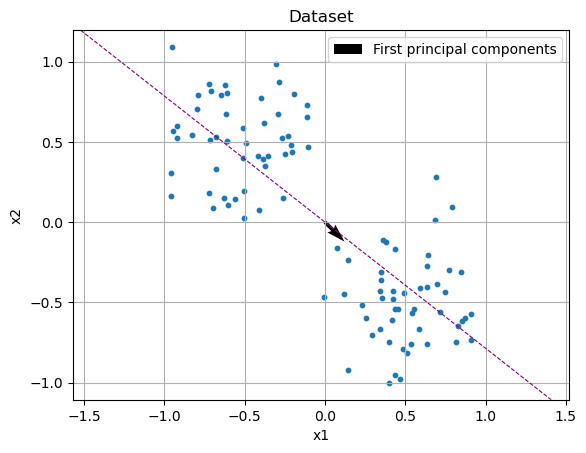

In [14]:
plt.scatter(*source1, s=10)
plt.axline((0, 0), slope=np.arctan(first_pc[1]/first_pc[0]), color='purple', lw=0.8, ls="--")
plt.quiver(0, 0, first_pc[0], first_pc[1], label="First principal components")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.title("Dataset")
plt.grid()
plt.legend()
plt.show()

In [15]:
#@title Plotting functions

# Oss. We suppose to have in "memory" first_pc & second_pc related to a first database
def plot_results(
    title: str,
    dataset: DataFrame,
    untr_W: ndarray,
    tr_W: ndarray,
    history_x1: list,
    history_x2: list,
    second_component: bool=False,
    filename: str=None):
  """
  :param title: title of the image
  :param dataset:
  :param untr_W: untrained weight
  :param tr_W: trained weight
  :param history_x1: evolution of weight x1 (during the updates)
  :param history_x2: evolution of weight x2 (during the updates)
  :param second_component: if True, then we display the second principal component
  :param filename: if not none, it corresponds to a name of image
  :return:
  """
  fig = plt.figure(figsize=(25,17),constrained_layout=True)
  fig.suptitle(title)
  gs = fig.add_gridspec(3, 6)

  ax0 = fig.add_subplot(gs[0, 1:3])
  ax0.set_title('Scatter-plot of dataset with untrained vector and First PC')
  ax0.scatter(*dataset)
  ax0.axline((0, 0), slope=np.arctan(first_pc[1]/first_pc[0]), color='purple', lw=0.8, ls="--", label="Direction of First pc")
  ax0.quiver(0, 0, first_pc[0], first_pc[1], label="First principal components",color="green")

  if second_component:
    ax0.quiver(0, 0, second_pc[0], second_pc[1], label="Second principal components",color="red")
    ax0.axline((0, 0), slope=np.arctan(second_pc[1]/second_pc[0]), color='orange', lw=0.8, ls="--", label="Direction of Second pc")

  ax0.quiver(0, 0, untr_W[0], untr_W[1], label="Untrained weights",color="blue")
  ax0.set_xlabel("x1")
  ax0.set_ylabel("x2")
  ax0.axis("equal")
  ax0.grid()
  ax0.legend()

  ax1 = fig.add_subplot(gs[0, 3:5])
  ax1.set_title('Scatter-plot of dataset with trained vector and First PC')
  ax1.scatter(*dataset)
  ax1.axline((0, 0), slope=np.arctan(first_pc[1]/first_pc[0]), color='purple', lw=0.8, ls="--", label="Direction of First pc")
  ax1.quiver(0, 0, first_pc[0], first_pc[1], label="First principal components",color="green")

  if second_component:
    ax1.quiver(0, 0, second_pc[0], second_pc[1], label="Second principal components",color="red")
    ax1.axline((0, 0), slope=np.arctan(second_pc[1]/second_pc[0]), color='orange', lw=0.8, ls="--", label="Direction of Second pc")

  ax1.quiver(0, 0, tr_W[0], tr_W[1], label="Trained weights",color="blue")
  ax1.set_xlabel("x1")
  ax1.set_ylabel("x2")
  ax1.axis("equal")
  ax1.grid()
  ax1.legend()

  ax2 = fig.add_subplot(gs[1, 0:2])
  ax2.set_title('Evolution of the weight X1 through the upgrades')
  ax2.plot(history_x1, label="x1")
  ax2.set_xlabel("Upgrades")
  ax2.set_ylabel("Values")
  ax2.grid()
  ax2.legend()

  ax3 = fig.add_subplot(gs[1, 2:4])
  ax3.set_title('Evolution of the weight X2 through the upgrades')
  ax3.plot(history_x2, label="x2")
  ax3.set_xlabel("Upgrades")
  ax3.set_ylabel("Values")
  ax3.grid()
  ax3.legend()

  ax4 = fig.add_subplot(gs[1, 4:6])
  ax4.set_title('Evolution of the norm of weight through the upgrades')
  ax4.plot([np.linalg.norm(np.array([a,b])) for (a,b) in zip(history_x1, history_x2)],
            label="norm(W)")
  ax4.set_xlabel("Upgrades")
  ax4.set_ylabel("Values")
  ax4.grid()
  ax4.legend()

  if filename is not None:
    plt.savefig("imgs/" + filename)

  plt.show()

# Oss. We suppose to have in "memory" first_pc & second_pc related to second database
def plot_results2(
    title: str,
    dataset:DataFrame,
    untr_W: ndarray,
    tr_W: ndarray,
    history_x1:list,
    history_x2:list,
    second_component:bool=False,
    filename:str=None):
  """
  :param title: title of the image
  :param dataset:
  :param untr_W: untrained weight
  :param tr_W: trained weight
  :param history_x1: evolution of weight x1 (during the updates)
  :param history_x2: evolution of weight x2 (during the updates)
  :param filename: if not none, it corresponds to the name of the image
  :return:
  """
  fig = plt.figure(figsize=(25,17),constrained_layout=True)
  fig.suptitle(title)
  gs = fig.add_gridspec(3, 6)

  origin_x, origin_y = 10, 2000

  ax0 = fig.add_subplot(gs[0, 1:3])
  ax0.set_title('Scatter-plot of dataset with untrained vector and First PC')
  ax0.scatter(*dataset)
  ax0.quiver(origin_x, origin_y, first_pc2[0], first_pc2[1], label="First principal components",color="green")

  if second_component:
    ax0.quiver(origin_x, origin_y, second_pc2[0], second_pc2[1], label="Second principal components",color="red")

  ax0.quiver(origin_x, origin_y, untr_W[0], untr_W[1], label="Untrained weights",color="blue")
  ax0.set_xlabel("x1")
  ax0.set_ylabel("x2")
  ax0.grid()
  ax0.legend()

  ax1 = fig.add_subplot(gs[0, 3:5])
  ax1.set_title('Scatter-plot of dataset with trained vector and First PC')
  ax1.scatter(*dataset)
  ax1.quiver(origin_x, origin_y, first_pc2[0], first_pc2[1], label="First principal components",color="green")

  if second_component:
    ax1.quiver(origin_x, origin_y, second_pc2[0], second_pc2[1], label="Second principal components",color="red")

  ax1.quiver(origin_x, origin_y, tr_W[0], tr_W[1], label="Trained weights",color="blue")
  ax1.set_xlabel("x1")
  ax1.set_ylabel("x2")
  ax1.grid()
  ax1.legend()

  ax2 = fig.add_subplot(gs[1, 0:2])
  ax2.set_title('Evolution of the weight X1 through the upgrades')
  ax2.plot(history_x1, label="x1")
  ax2.set_xlabel("Upgrades")
  ax2.set_ylabel("Values")
  ax2.grid()
  ax2.legend()

  ax3 = fig.add_subplot(gs[1, 2:4])
  ax3.set_title('Evolution of the weight X2 through the upgrades')
  ax3.plot(history_x2, label="x2")
  ax3.set_xlabel("Upgrades")
  ax3.set_ylabel("Values")
  ax3.grid()
  ax3.legend()

  ax4 = fig.add_subplot(gs[1, 4:6])
  ax4.set_title('Evolution of the norm of weight through the upgrades')
  ax4.plot([np.linalg.norm(np.array([a,b])) for (a,b) in zip(history_x1, history_x2)],
            label="norm(W)")
  ax4.set_xlabel("Upgrades")
  ax4.set_ylabel("Values")
  ax4.grid()
  ax4.legend()

  if filename is not None:
    plt.savefig("imgs/" + filename)

  plt.show()

In [16]:
class Hebbian_learning:
  def __init__(self,
               source: ndarray,
               epochs: int = 2, 
               lr: float = 0.1,
               threshold: float = 1e-03):

    self.__source = source # Dataset
    self.__epochs = epochs # Number of max epochs to perform
    self.__lr = lr #l Learning rate
    self.__threshold = threshold # Threshold for early stopping
    self.W = random.uniform(-1, 1, 2) # weights of the network

    self.history_x1 = [] 
    self.history_x2 = []

  # Protected method that will be overridden to implement further rules
  def _hebbian_rule(self, u:ndarray) -> ndarray:
    return (self.W @ u) * u

  def __call__(self):
    
    current_epoch, norm = 0, 0
    flag, pred_W = False, None

    while current_epoch < self.__epochs and not flag:

      # iterate each element (composed by 2 values x1 & x2)
      for u in random.permutation(self.__source):
        
        # upgrade the weights based on hebbian rule
        # Oss. we are assuming that inside the constant "lr" there is also
        # the constant value "h" used to perform the differential equation
        # by the euler's method
        self.W += self.__lr * self._hebbian_rule(u)

        # we keep track the weights and the norm for each upgrade
        self.history_x1.append(self.W[0])
        self.history_x2.append(self.W[1])

      # we're also implementing the early stopping based on norm
      flag = True if pred_W is not None and\
                    np.linalg.norm(self.W - pred_W) < self.__threshold else False

      pred_W = copy(self.W)
      current_epoch += 1

## Assignment 1: Basic Hebbian Learning

In the basic Hebbian learning, the weights have no limit in the values that they can reach.

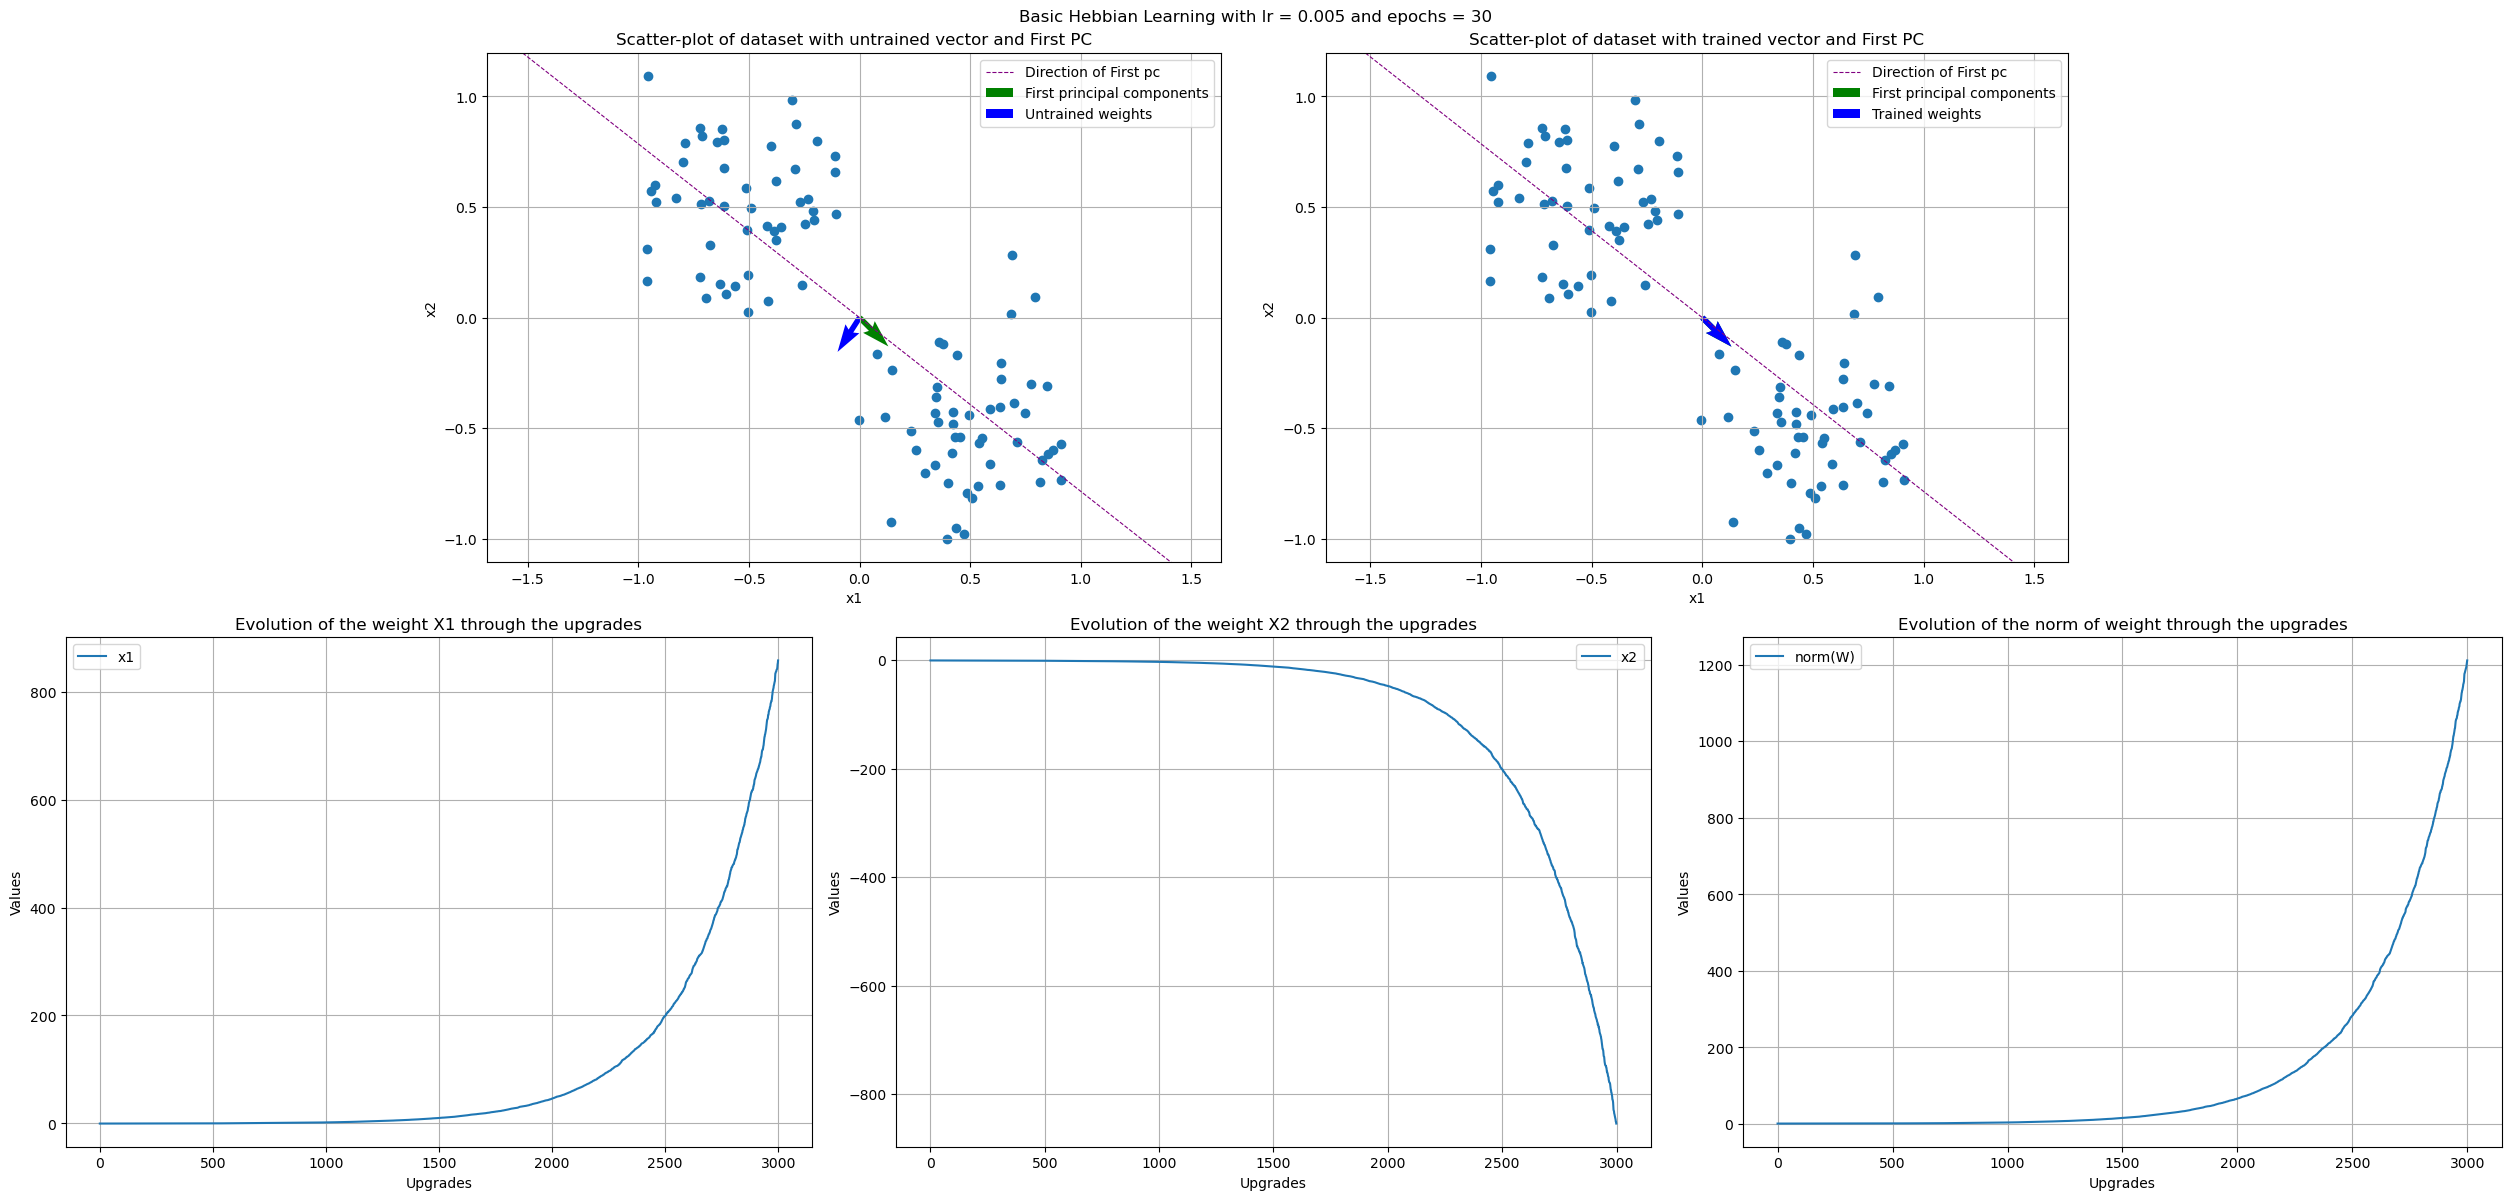

In [17]:
hebbianL = Hebbian_learning(source1.T, lr=0.005, epochs=30)
untrained_W = copy(hebbianL.W)
hebbianL()

plot_results(
    "Basic Hebbian Learning with lr = 0.005 and epochs = 30",
    source1,
    untrained_W,
    hebbianL.W,
    hebbianL.history_x1,
    hebbianL.history_x2,
    filename="01 - Hebbian lr 0_005 epochs 30")

## Assignment 2: Oja rule

In this variant of Hebbian learning, we apply a constraint over the sum of the squares of weights, this leads to introduce the competition between weights

In [18]:
class Oja_rule(Hebbian_learning):
  def __init__(self, alpha:float, **kwargs):
    super().__init__(**kwargs)
    self.alpha = alpha

  def _hebbian_rule(self, u:ndarray)->ndarray:
    v =  self.W @ u
    return (v * u) - self.alpha * (np.power(v, 2) * self.W)

### Configuration 1

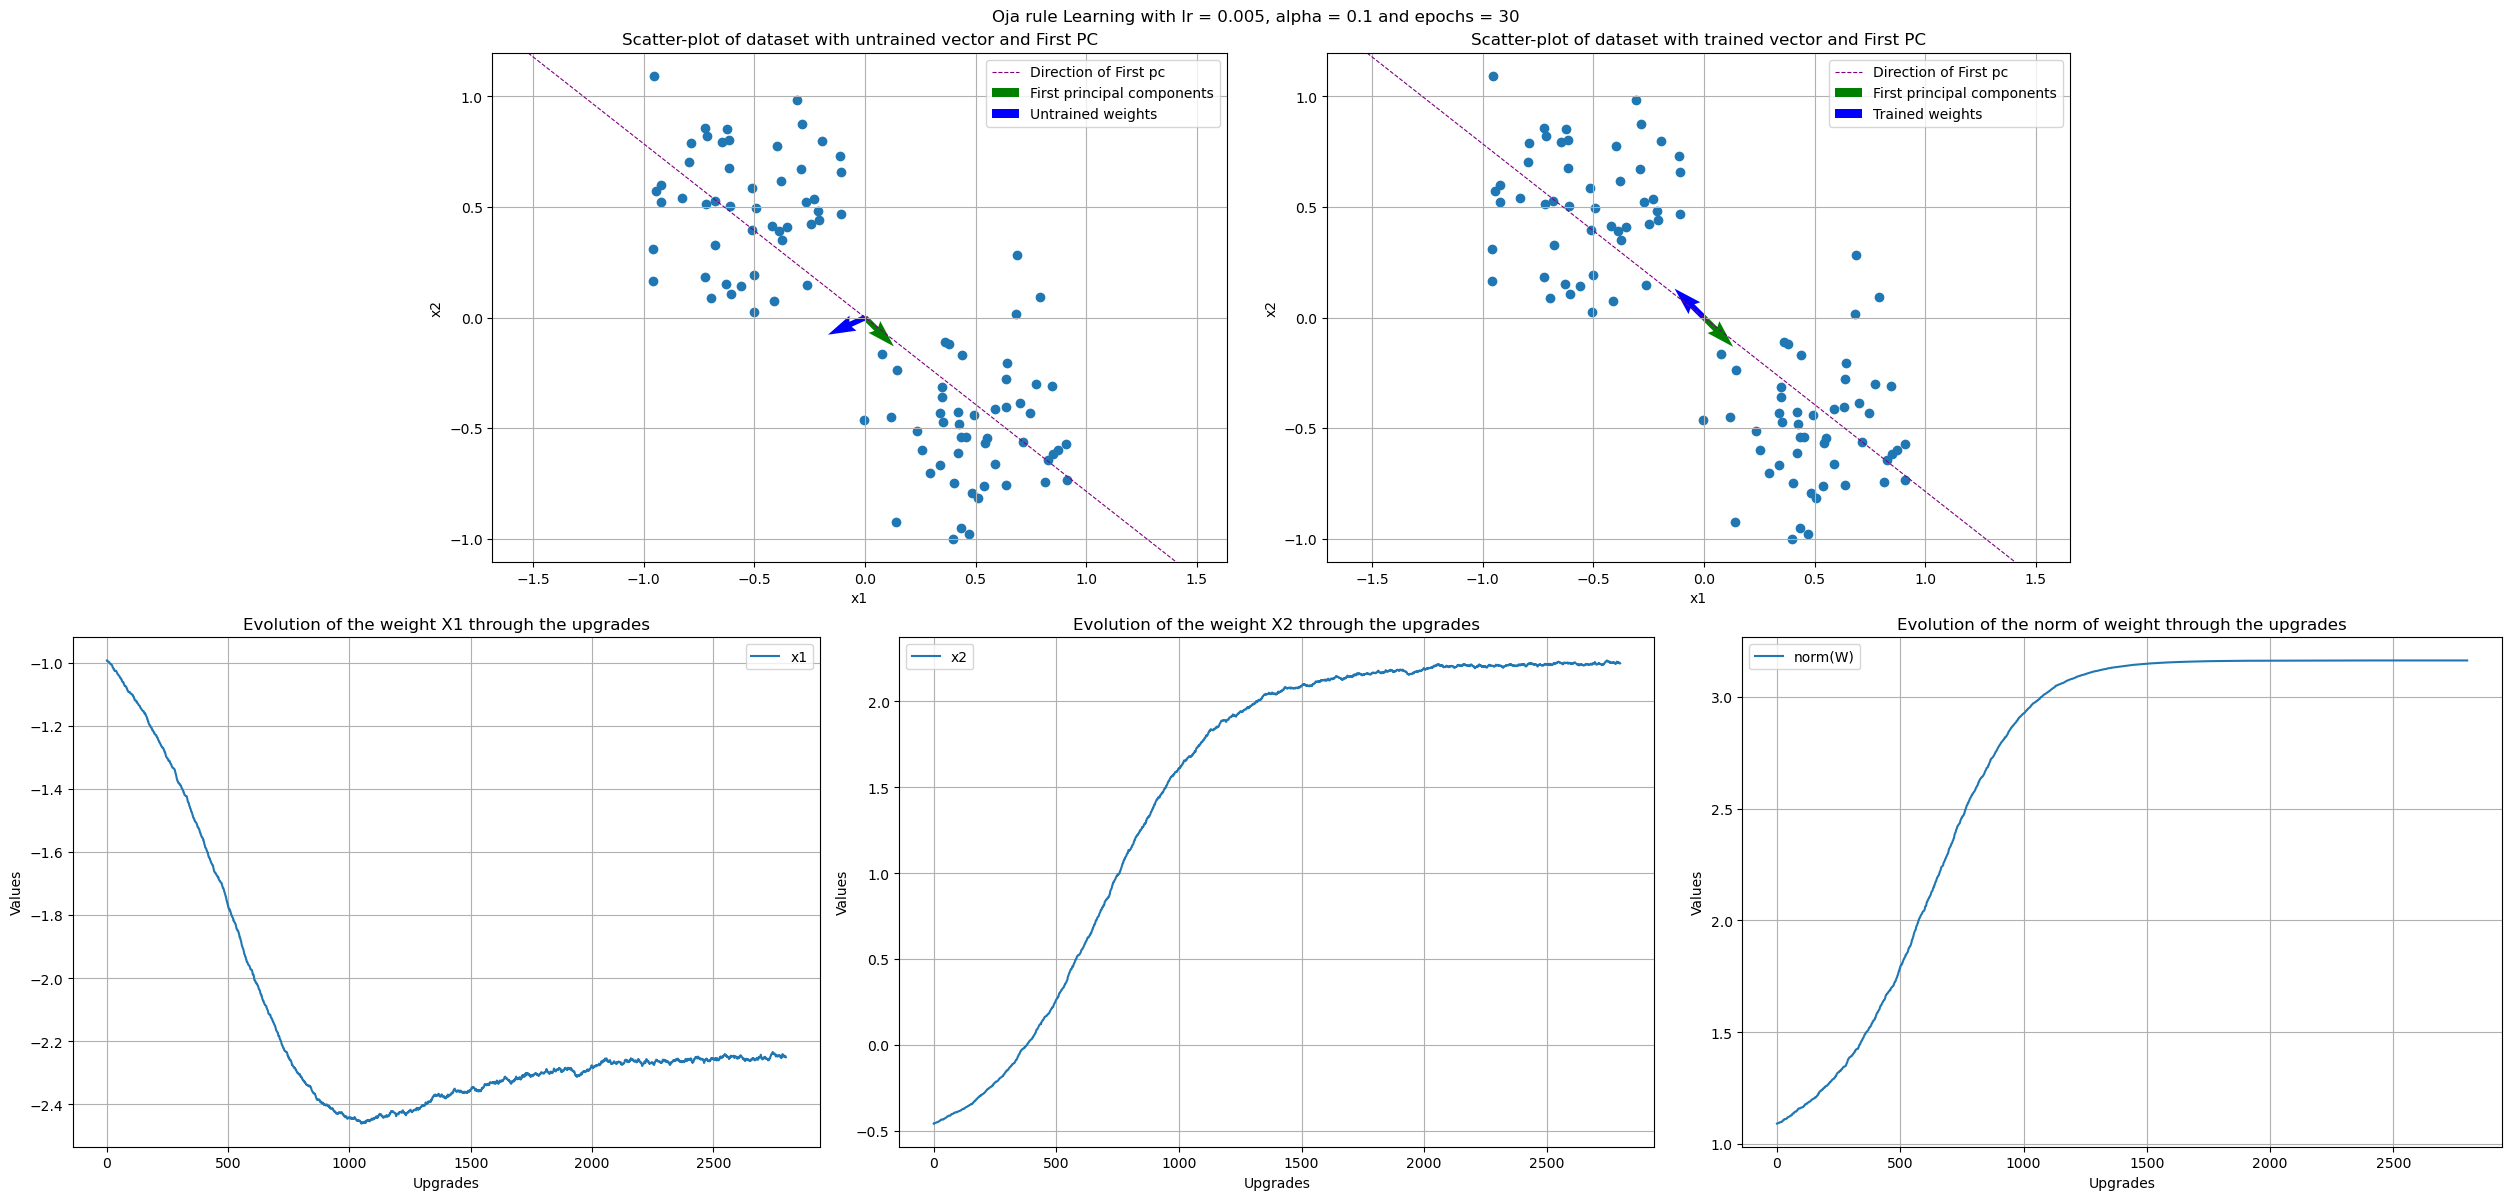

In [19]:
oja_rule = Oja_rule(alpha = 0.1, source = source1.T, lr=0.005, epochs=30)
untrained_W = copy(oja_rule.W)
oja_rule()

plot_results(
    "Oja rule Learning with lr = 0.005, alpha = 0.1 and epochs = 30",
    source1,
    untrained_W,
    oja_rule.W,
    oja_rule.history_x1,
    oja_rule.history_x2,
    filename="02 - Oja rule lr 0_005 epochs 30 alpha 0_1")

In the oja rule, we now that the squared norm tends to 1/alpha

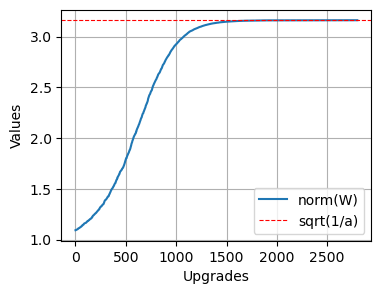

In [20]:
alpha = 0.1
plt.figure(figsize=(4,3))
plt.plot([np.linalg.norm(np.array([a,b])) for (a,b) in zip(oja_rule.history_x1, oja_rule.history_x2)], label="norm(W)")
plt.axhline(y = np.sqrt(1/alpha), color="red", label="sqrt(1/a)", lw=0.8, ls="--")
plt.xlabel("Upgrades")
plt.ylabel("Values")
plt.grid()
plt.legend()  
plt.show()

### Configuration 2

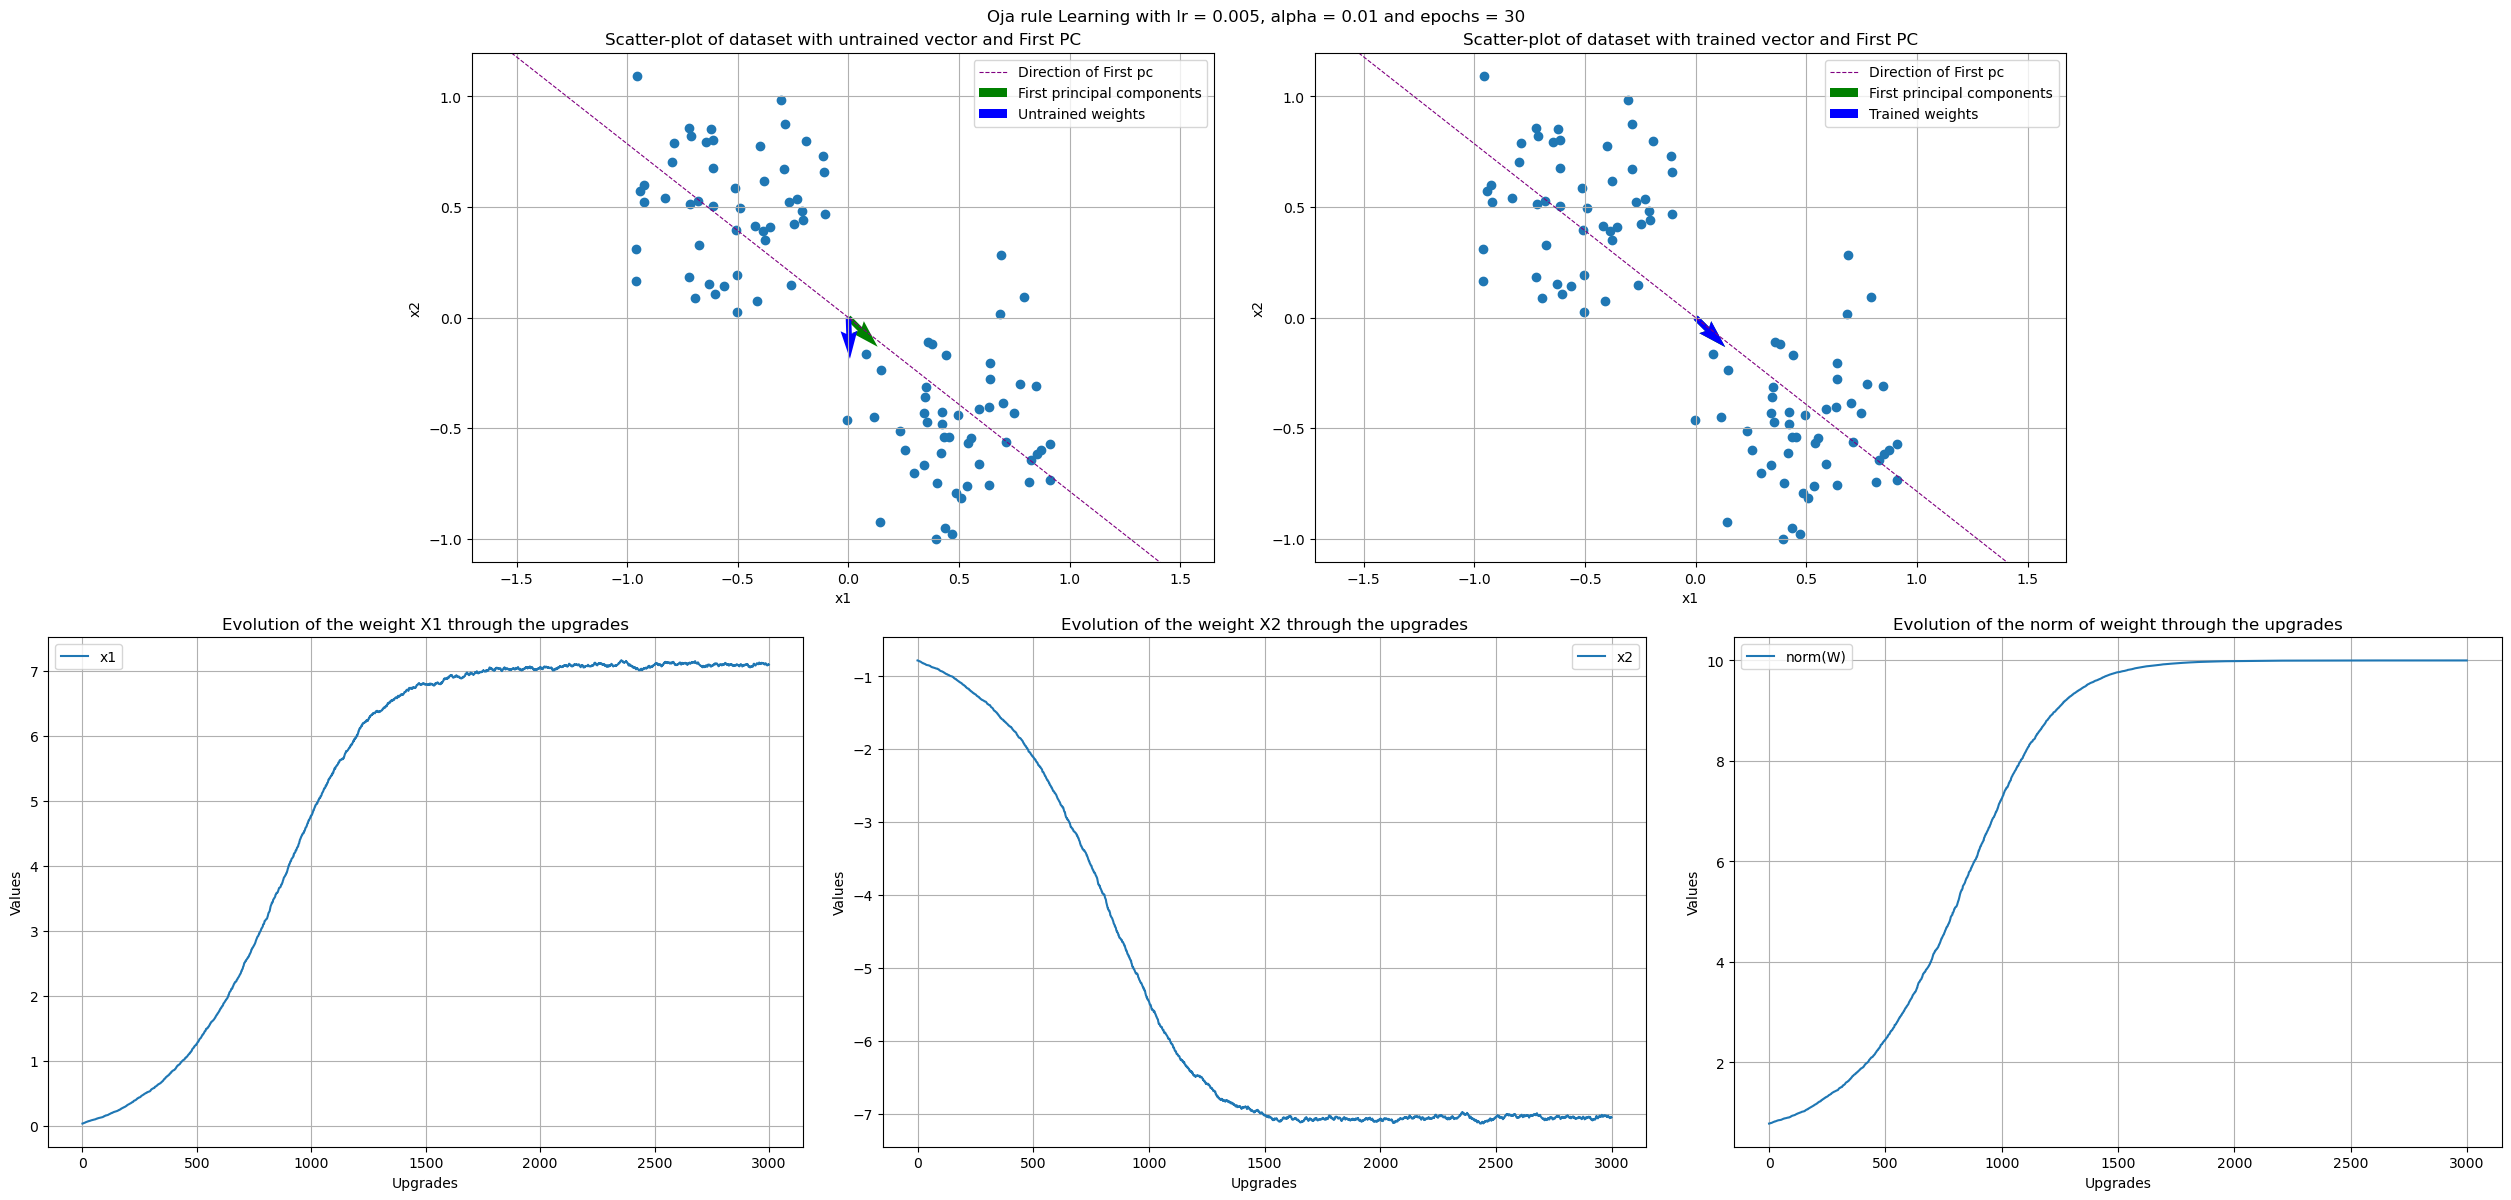

In [21]:
oja_rule = Oja_rule(alpha = 0.01, source = source1.T, lr=0.005, epochs=30)
untrained_W = copy(oja_rule.W)
oja_rule()

plot_results(
    "Oja rule Learning with lr = 0.005, alpha = 0.01 and epochs = 30",
    source1,
    untrained_W,
    oja_rule.W,
    oja_rule.history_x1,
    oja_rule.history_x2,
    filename="03 - Oja rule lr 0_005 epochs 30 alpha 0_01")

### Configuration 3

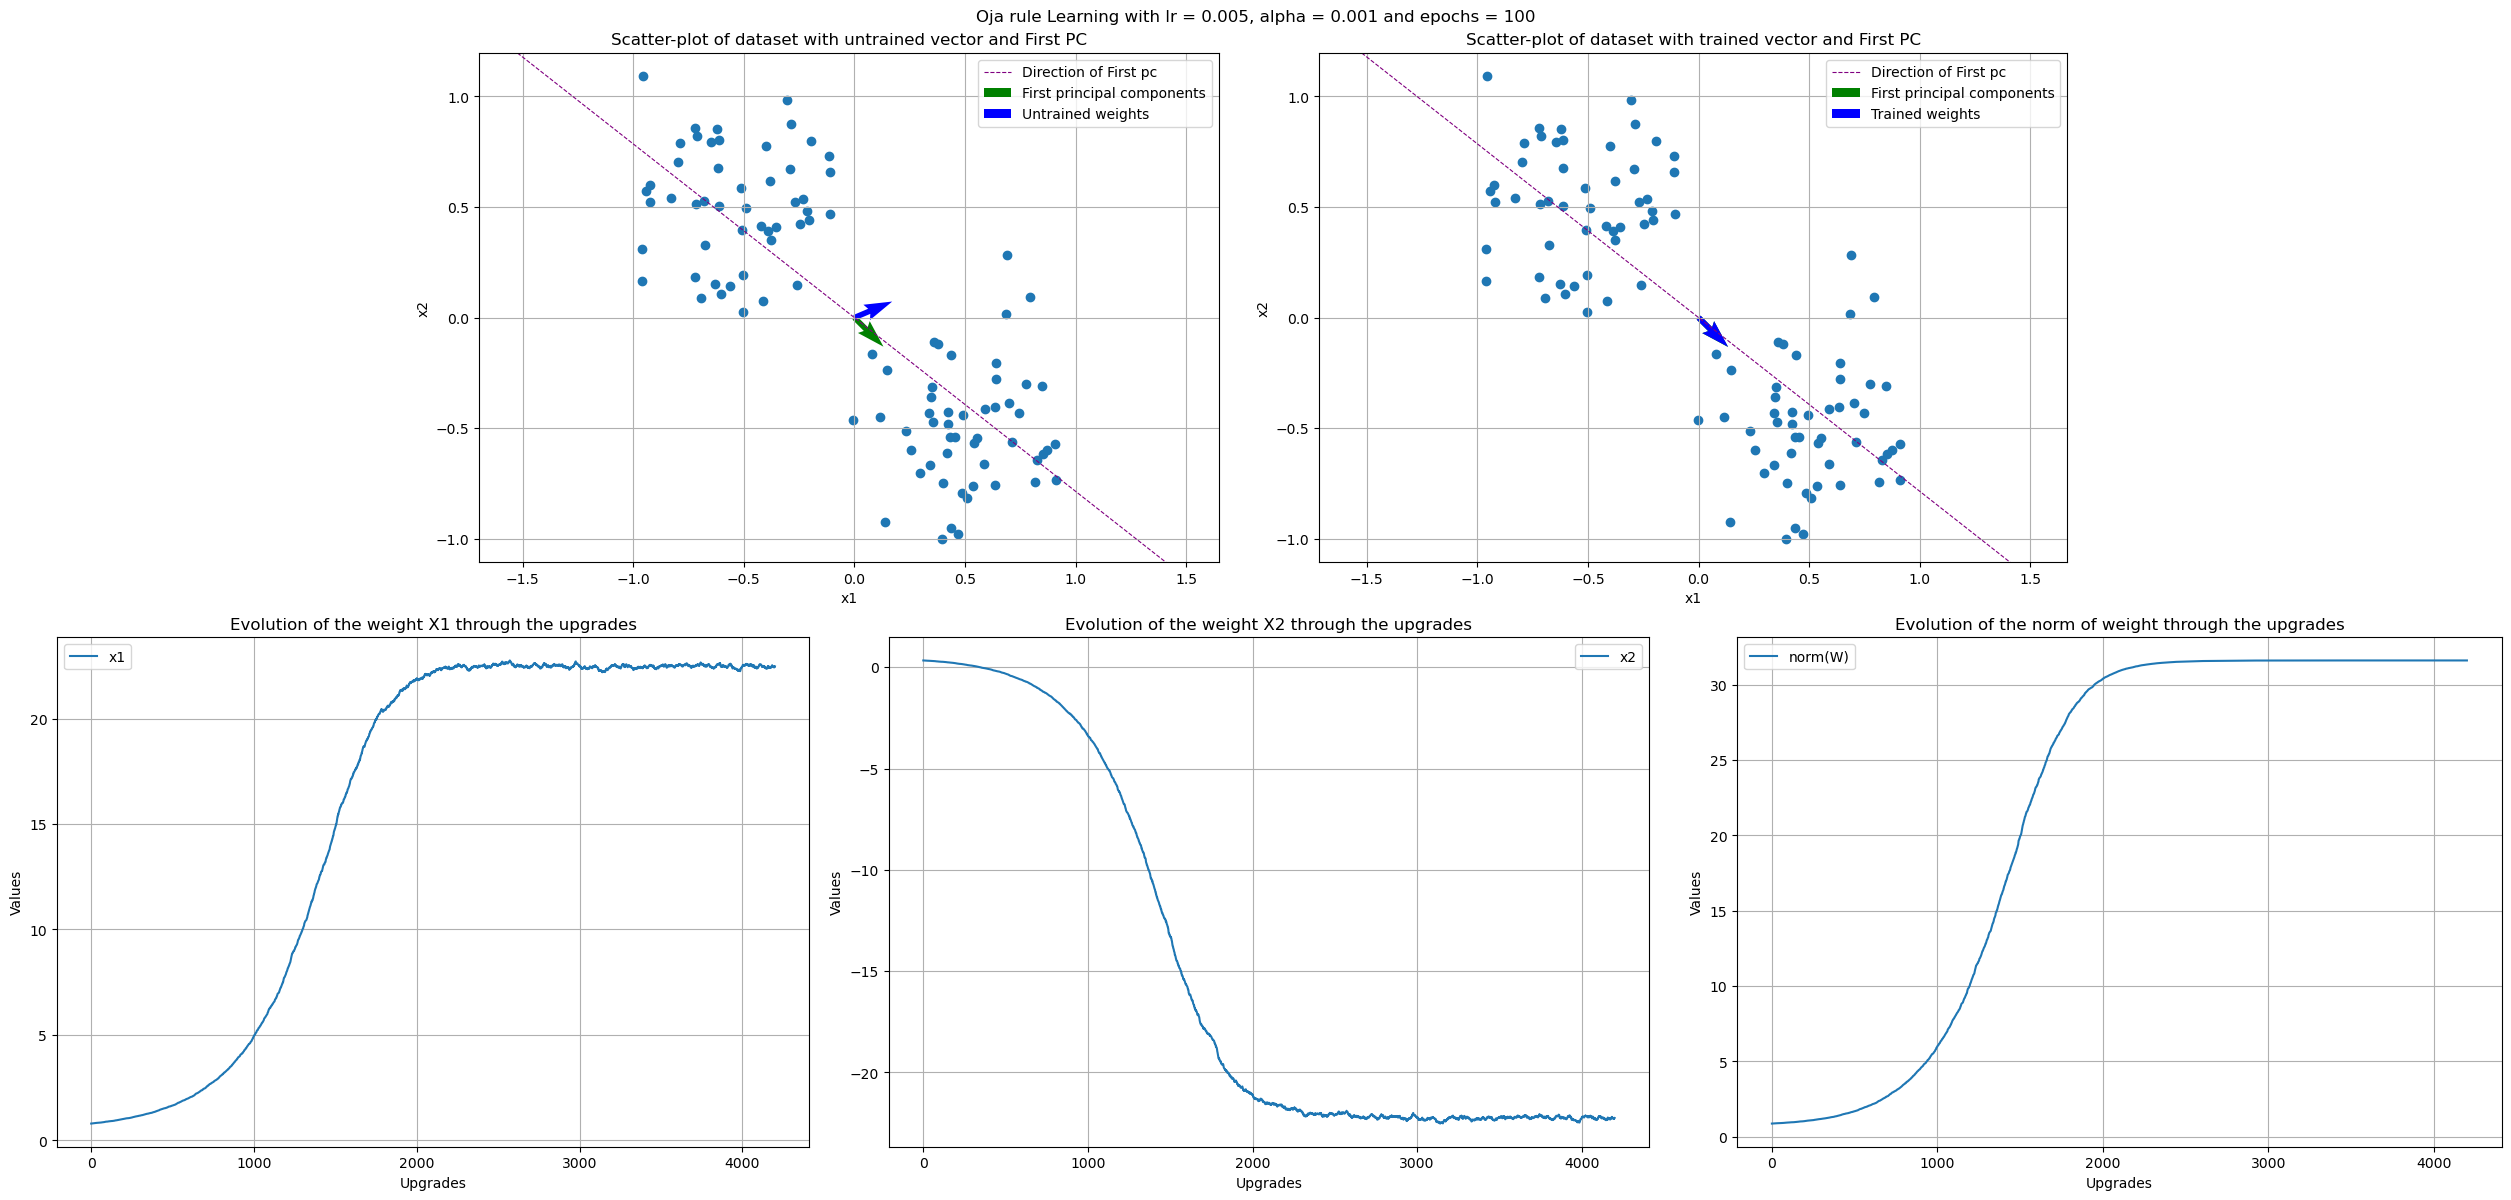

In [22]:
oja_rule = Oja_rule(alpha = 0.001, source = source1.T, lr=0.005, epochs=100)
untrained_W = copy(oja_rule.W)
oja_rule()

plot_results(
    "Oja rule Learning with lr = 0.005, alpha = 0.001 and epochs = 100",
    source1,
    untrained_W,
    oja_rule.W,
    oja_rule.history_x1,
    oja_rule.history_x2,
    filename="04 - Oja rule lr 0_005 epochs 100 alpha 0_001")

## Assignment 3: Subtractive normalization

As in the former case, the weights feel free to ground without any bound. In this case, we introduce a rigidly constraint on the sun of weights because the subtractive normalization does not allow the hebbian term to change n*w.

In [23]:
class Subtractive(Hebbian_learning):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.one = ones(2)
            
  def _hebbian_rule(self, u:ndarray)->ndarray:
    v =  self.W @ u
    return v * u - (v * (self.one.T @ u) * self.one)/2

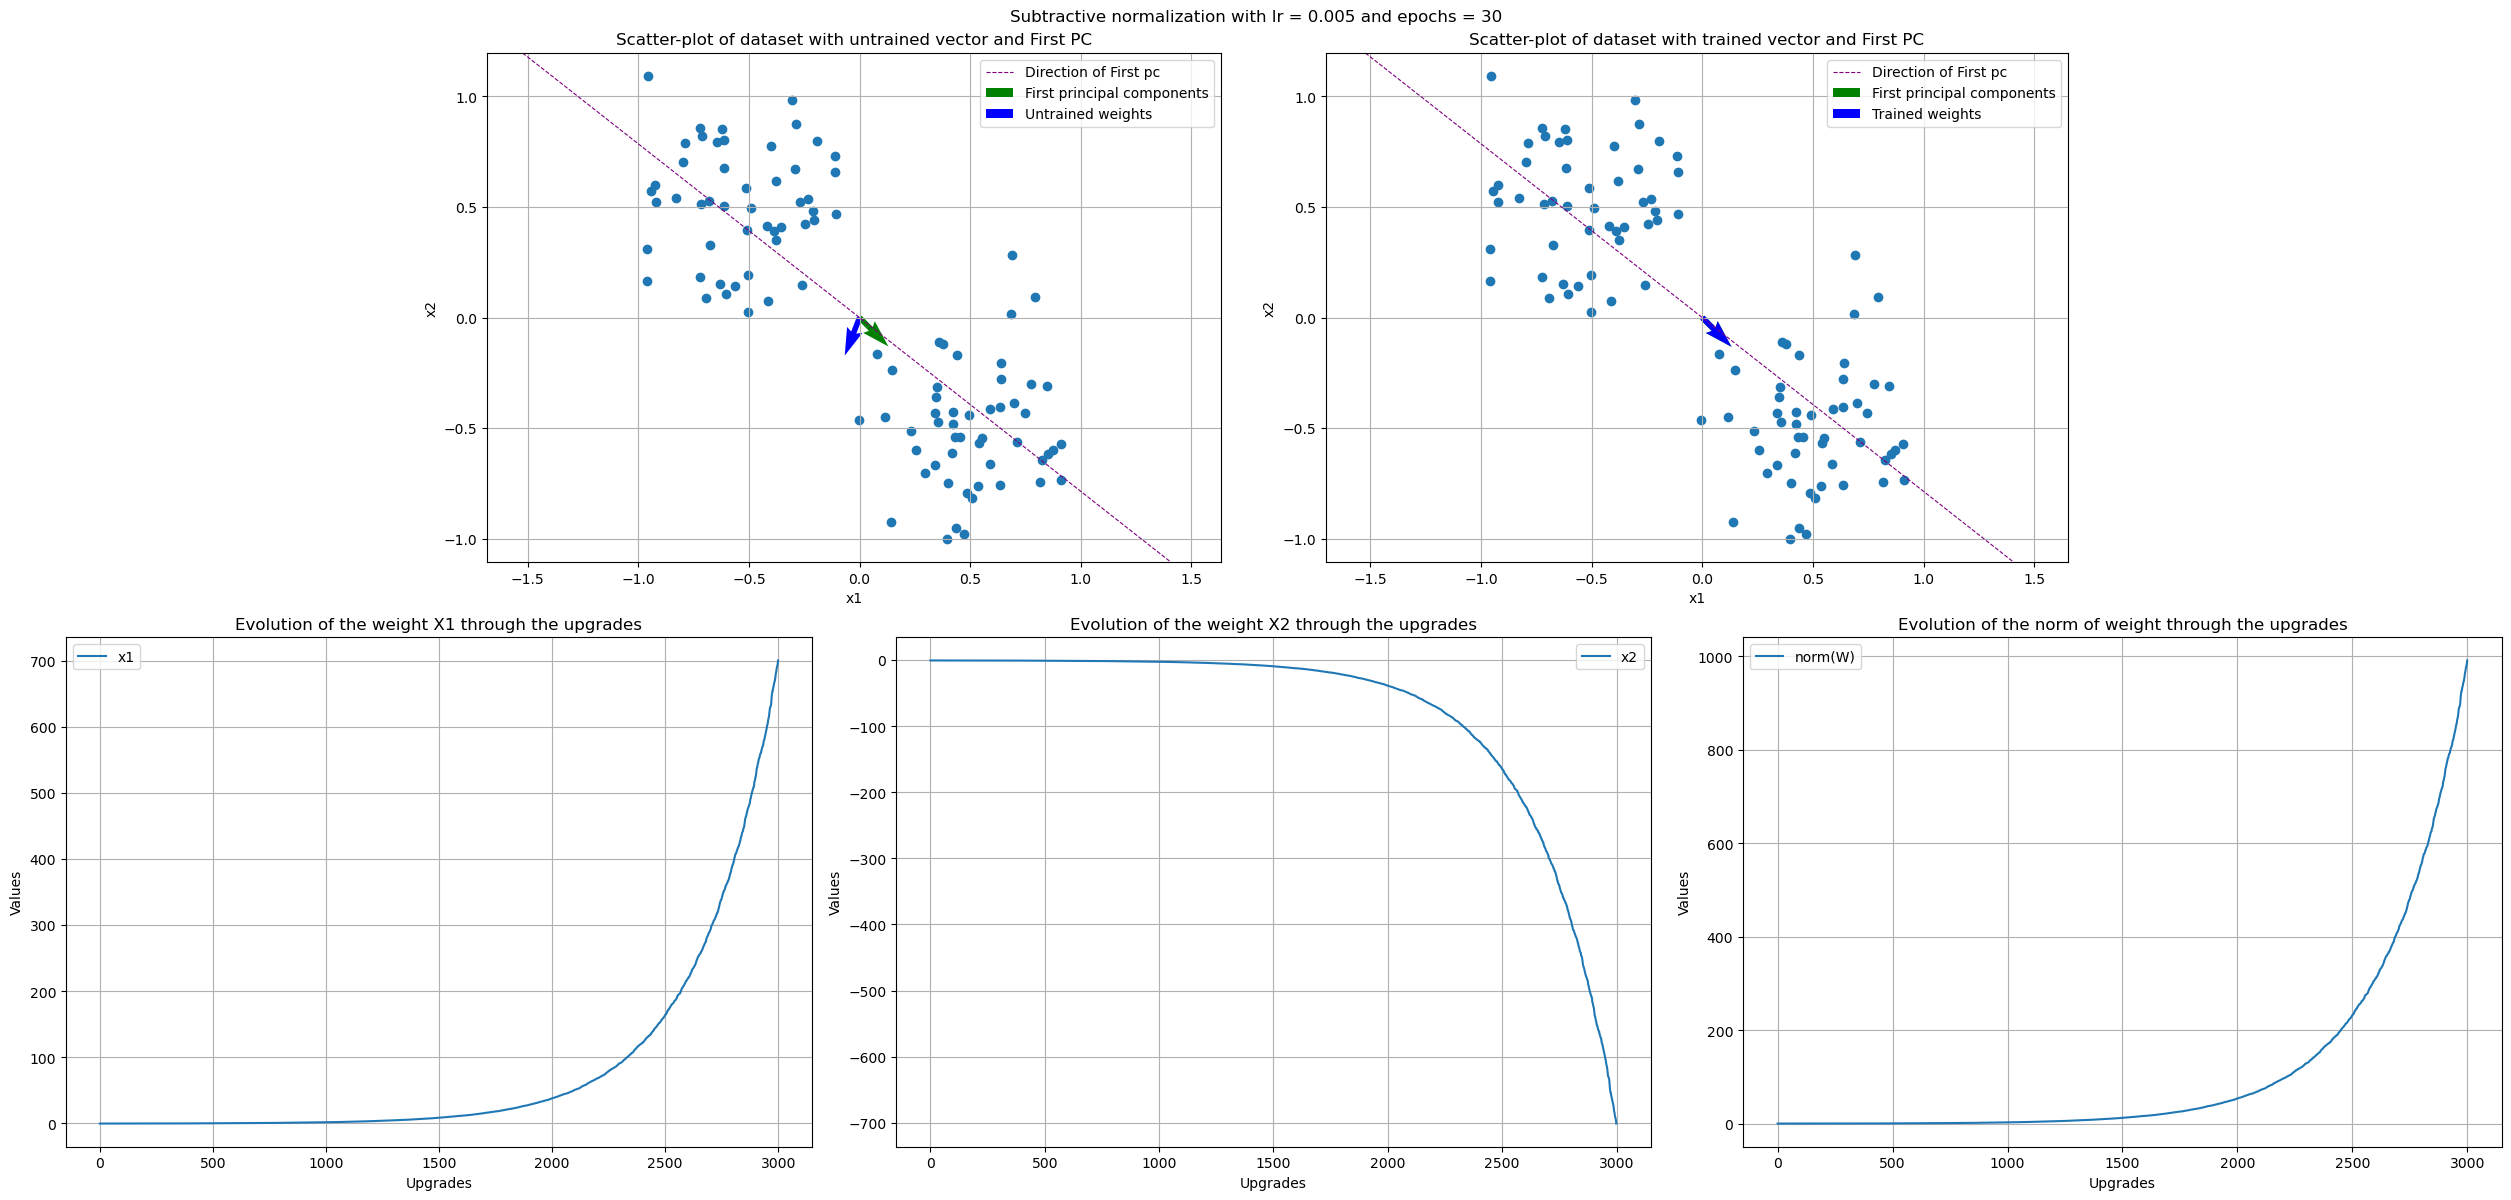

In [24]:
subtractive = Subtractive(source = source1.T, lr=0.005, epochs=30)
untrained_W = copy(subtractive.W)
subtractive()

plot_results(
    "Subtractive normalization with lr = 0.005 and epochs = 30",
    source1,
    untrained_W,
    subtractive.W,
    subtractive.history_x1,
    subtractive.history_x2,
    filename="05 - Subtractive lr 0_005 epochs 30")

## Bonus Track Assignment 1 – BCM Rule

In [25]:
class BCM_Rule(Hebbian_learning):
  def __init__(self, theta = 0.1, theta_lr = 0.1, **kwargs):
    super().__init__(**kwargs)

    self.__theta = theta
    self.__theta_lr = theta_lr
  
  def __theta_adapt(self, v:ndarray):
    """
    Oss. We assume (as previously done for the classical hebbian rule) that the theta_lr
    constant includes also the Tau_theta. We use the euler's method to perform the differential
    equation
    """
    self.__theta += self.__theta_lr * (np.power(v,2) - self.__theta)

  def _hebbian_rule(self, u:ndarray)->ndarray:
    v =  self.W @ u
    self.__theta_adapt(v)
    return v * u * (v - self.__theta)

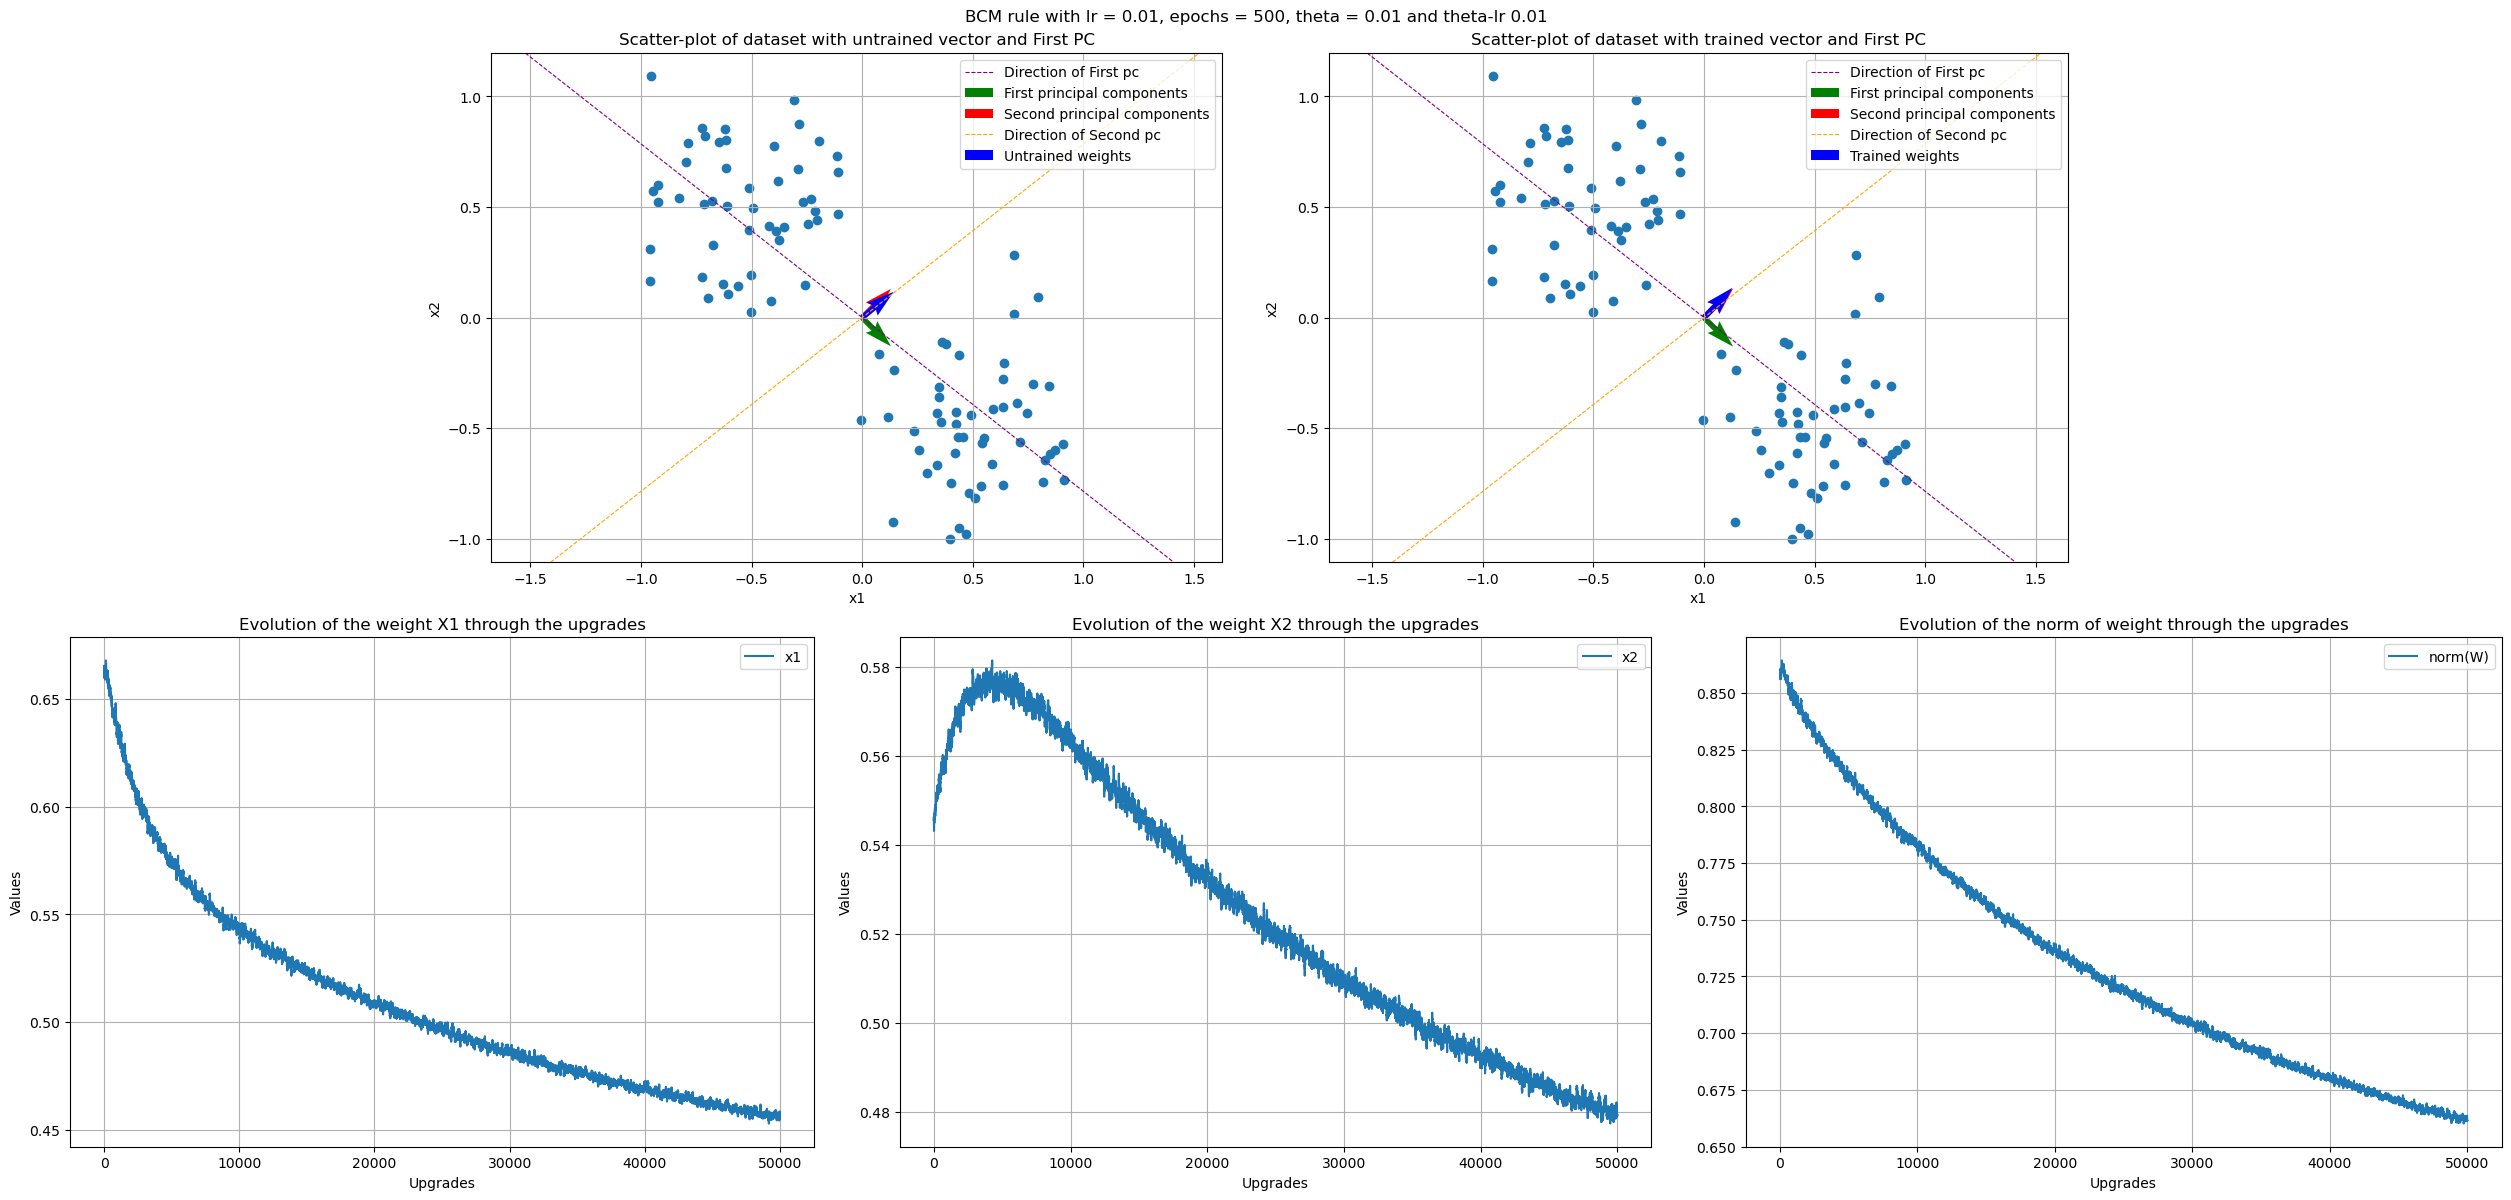

In [26]:
bcm_rule = BCM_Rule(theta = 0.01,
                    theta_lr = 0.01,
                    source = source1.T,
                    lr=0.01,
                    epochs=500,
                    threshold=1e-05)

untrained_W = copy(bcm_rule.W)
bcm_rule()

plot_results(
    "BCM rule with lr = 0.01, epochs = 500, theta = 0.01 and theta-lr 0.01",
    source1,
    untrained_W,
    bcm_rule.W,
    bcm_rule.history_x1,
    bcm_rule.history_x2,
    second_component=True,
    filename="06 - BCM lr 0_01 epochs 500 theta 0_01 theta_lr 0_01")

## Bonus Track Assignment 2 – Covariance Rule

In [27]:
class Covariance_rule(Hebbian_learning):
  def __init__(self, theta = 0.1, **kwargs):
    super().__init__(**kwargs)

    self.__theta = theta
  
  def _hebbian_rule(self, u:ndarray)->ndarray:
    v =  self.W @ u
    return v * (u - self.__theta)

### Configuration 1

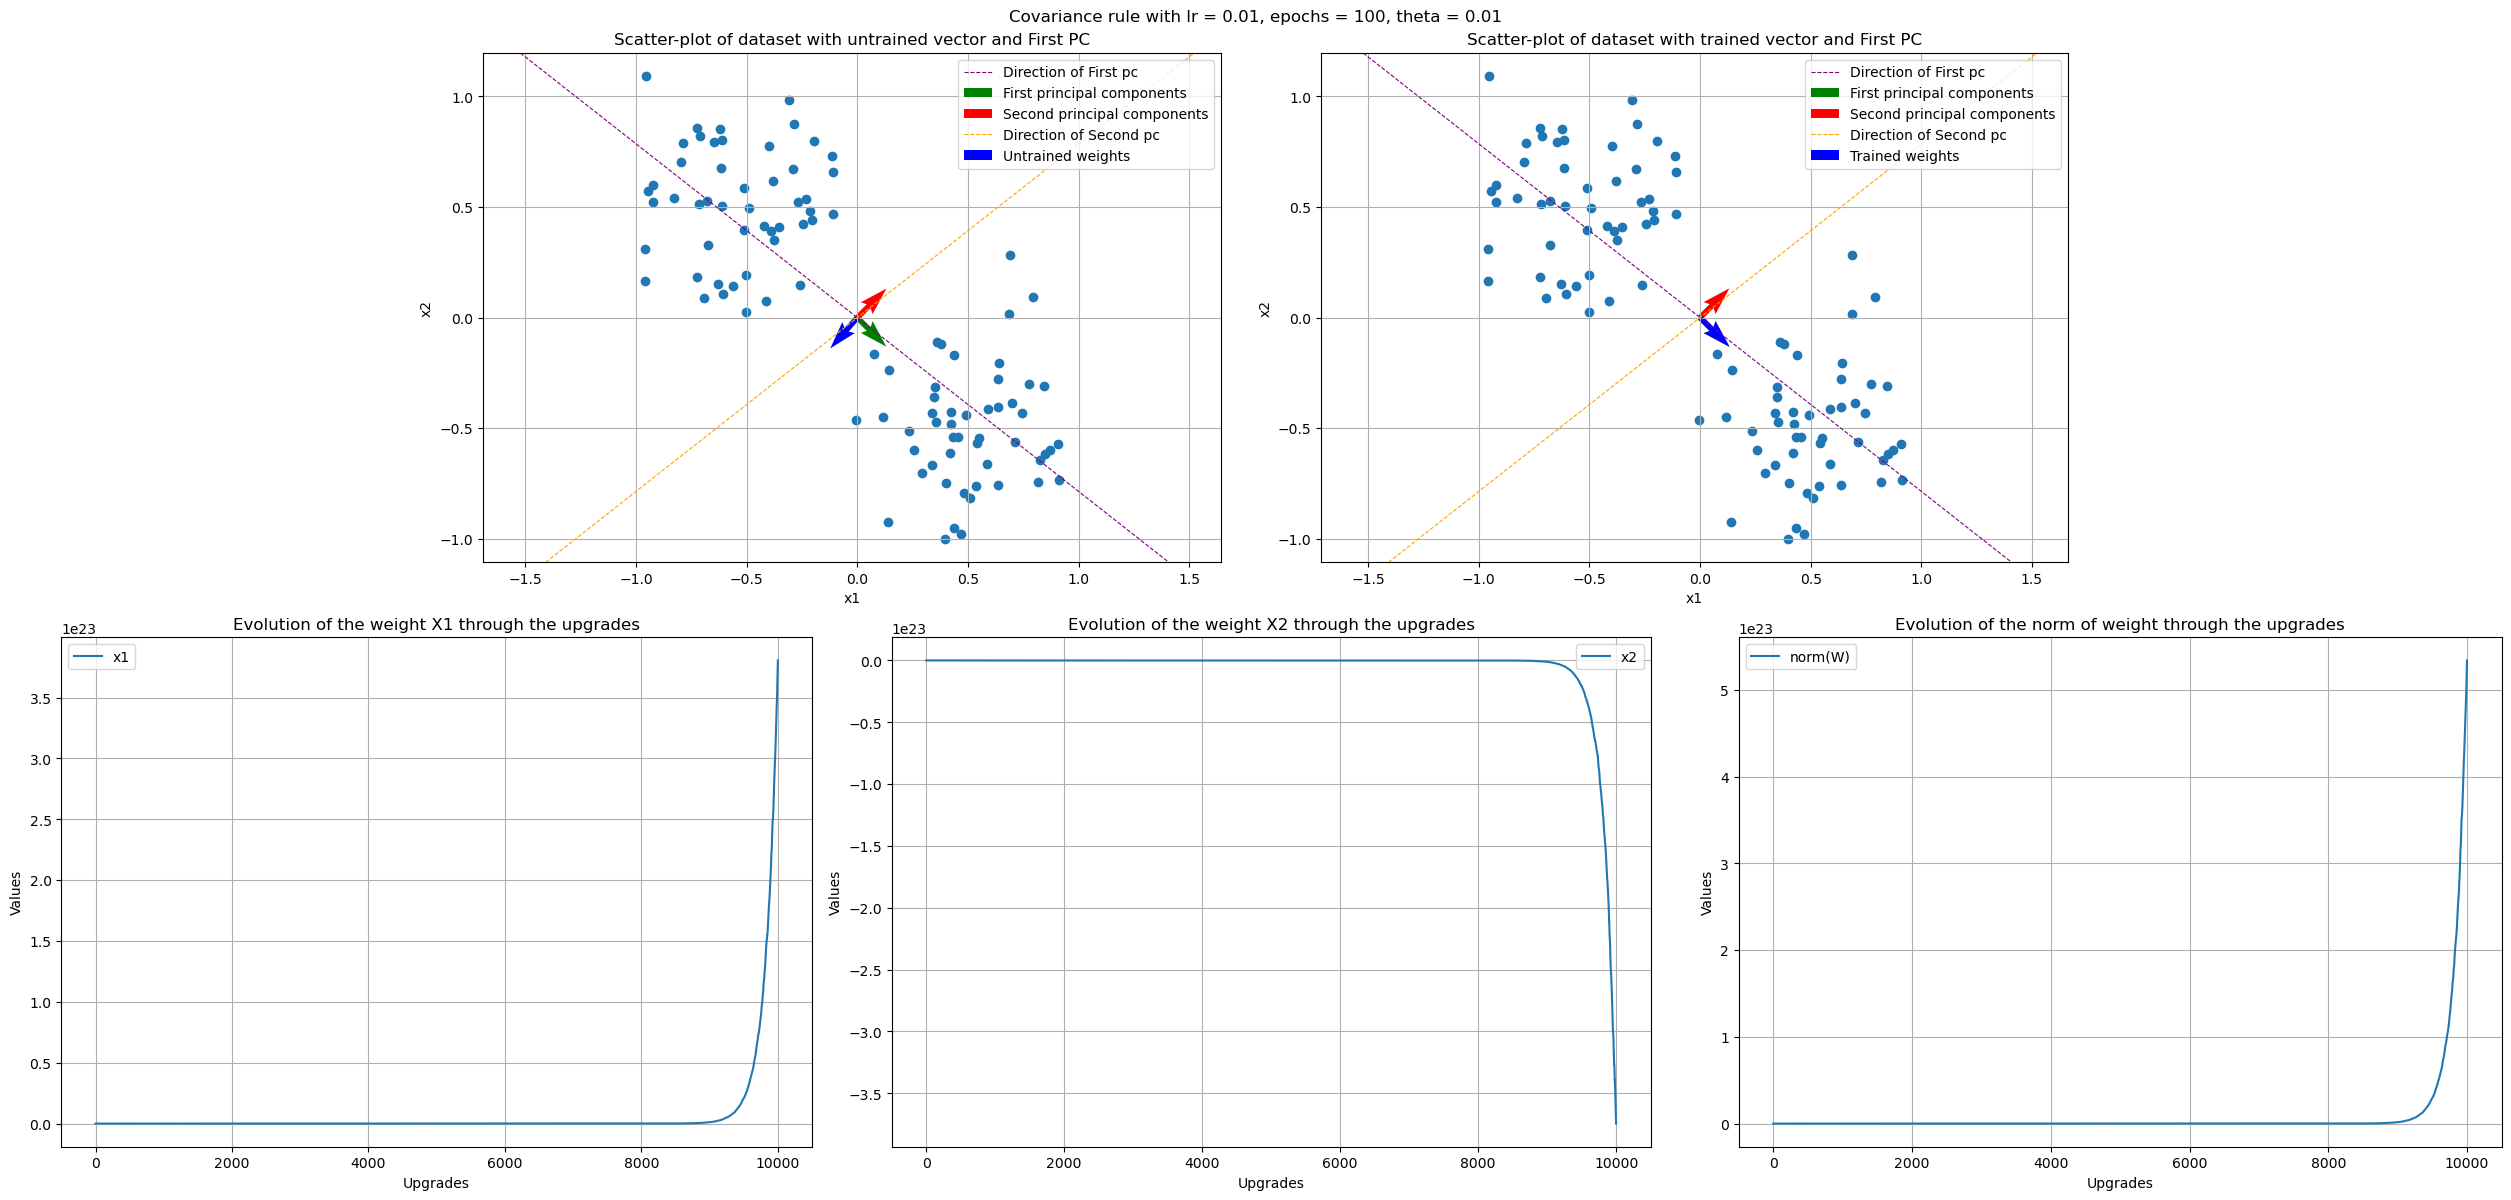

In [28]:
conv_rule = Covariance_rule(theta = 0.01,
                           source = source1.T,
                           lr=0.01,
                           epochs=100,
                           threshold=1e-05)

untrained_W = copy(conv_rule.W)
conv_rule()

plot_results(
    "Covariance rule with lr = 0.01, epochs = 100, theta = 0.01",
    source1,
    untrained_W,
    conv_rule.W,
    conv_rule.history_x1, 
    conv_rule.history_x2,
    second_component=True,
    filename="07 - Covariance lr 0_01 epochs 100 theta 0_01")

### Configuration 2

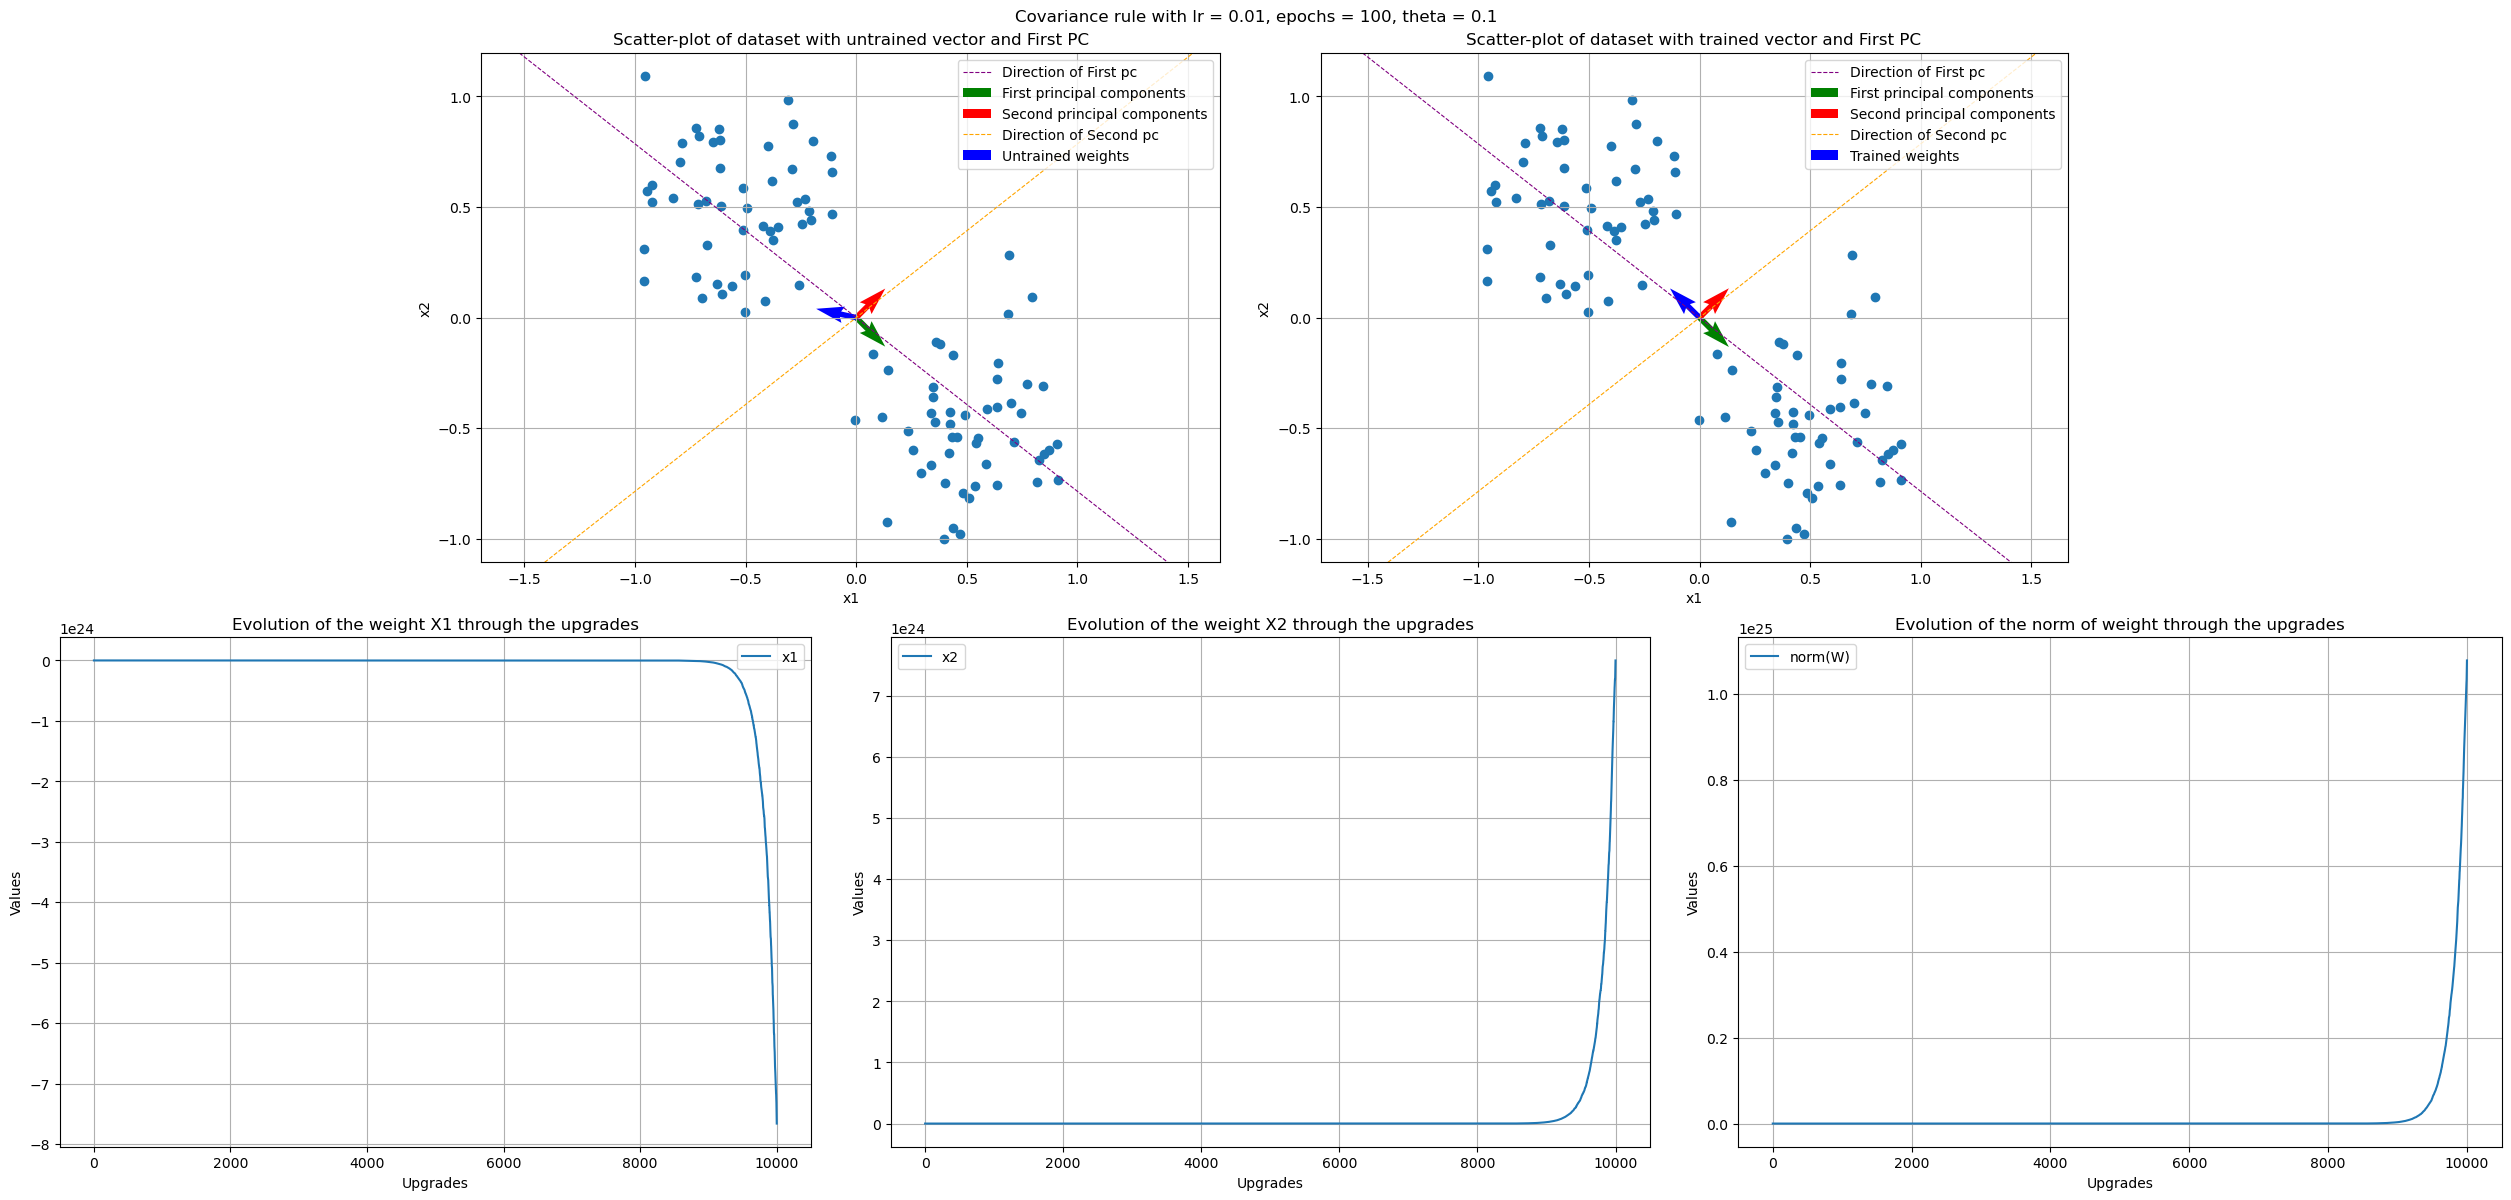

In [29]:
conv_rule = Covariance_rule(theta = 0.1,
                           source = source1.T,
                           lr=0.01,
                           epochs=100,
                           threshold=1e-05)

untrained_W = copy(conv_rule.W)
conv_rule()

plot_results(
    "Covariance rule with lr = 0.01, epochs = 100, theta = 0.1",
    source1,
    untrained_W,
    conv_rule.W,
    conv_rule.history_x1,
    conv_rule.history_x2,
    second_component=True,
    filename="08 - Covariance lr 0_01 epochs 100 theta 0_1")

### Configuration 3

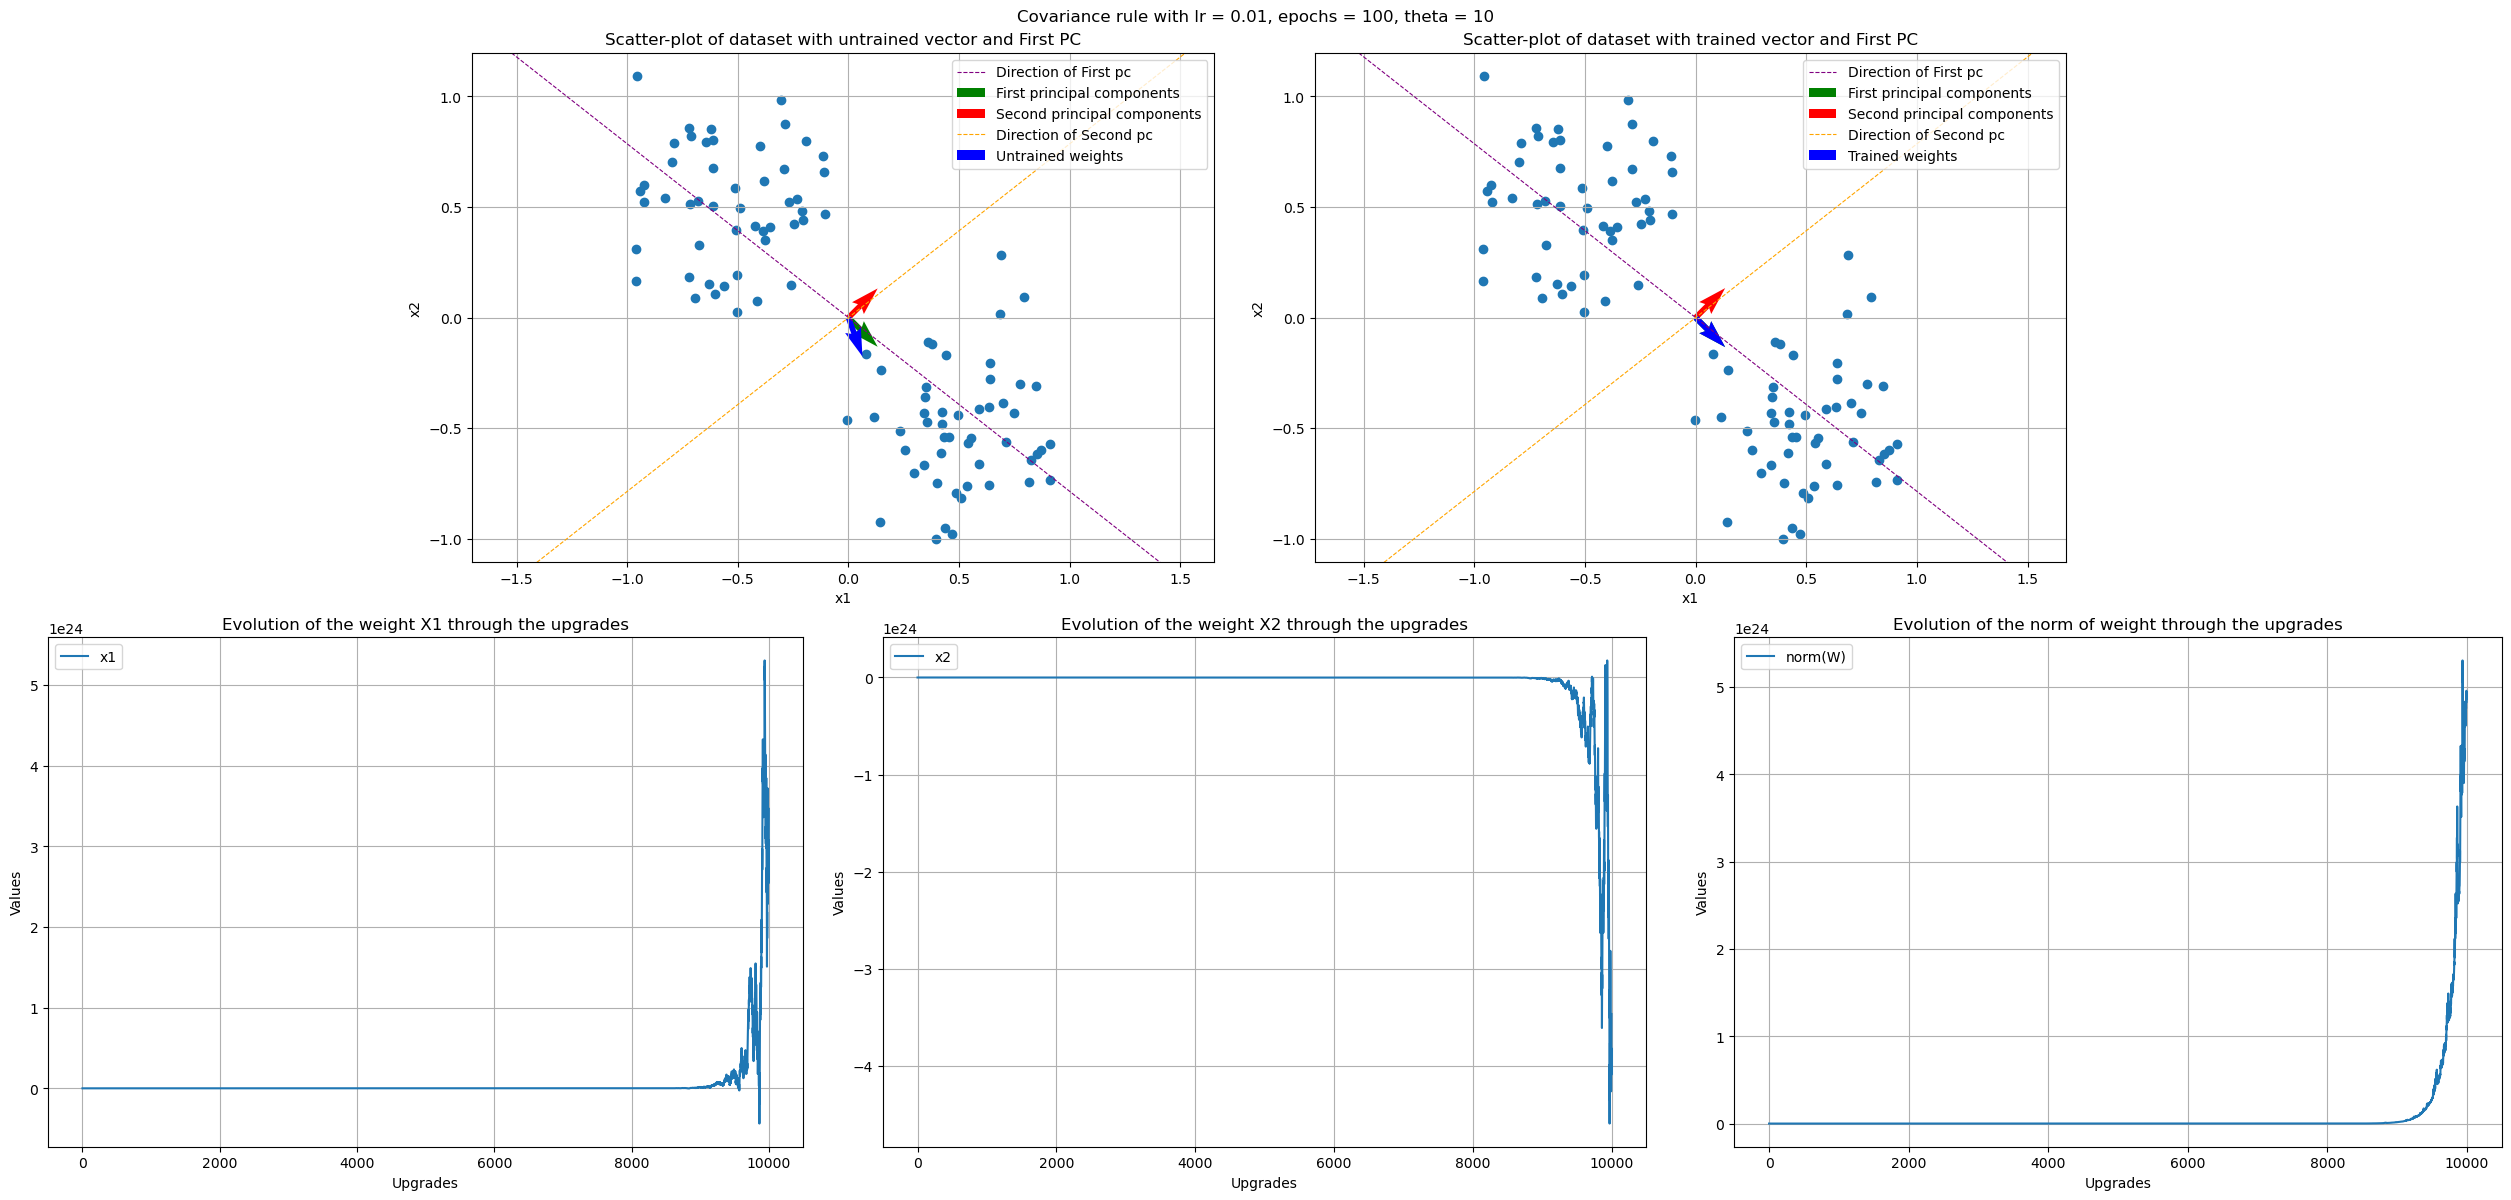

In [30]:
conv_rule = Covariance_rule(theta = 10,
                           source = source1.T,
                           lr=0.01,
                           epochs=100,
                           threshold=1e-05)

untrained_W = copy(conv_rule.W)
conv_rule()

plot_results(
    "Covariance rule with lr = 0.01, epochs = 100, theta = 10",
    source1,
    untrained_W,
    conv_rule.W,
    conv_rule.history_x1,
    conv_rule.history_x2,
    second_component=True,
    filename="09 - Covariance lr 0_01 epochs 100 theta 10")

### Configuration 4

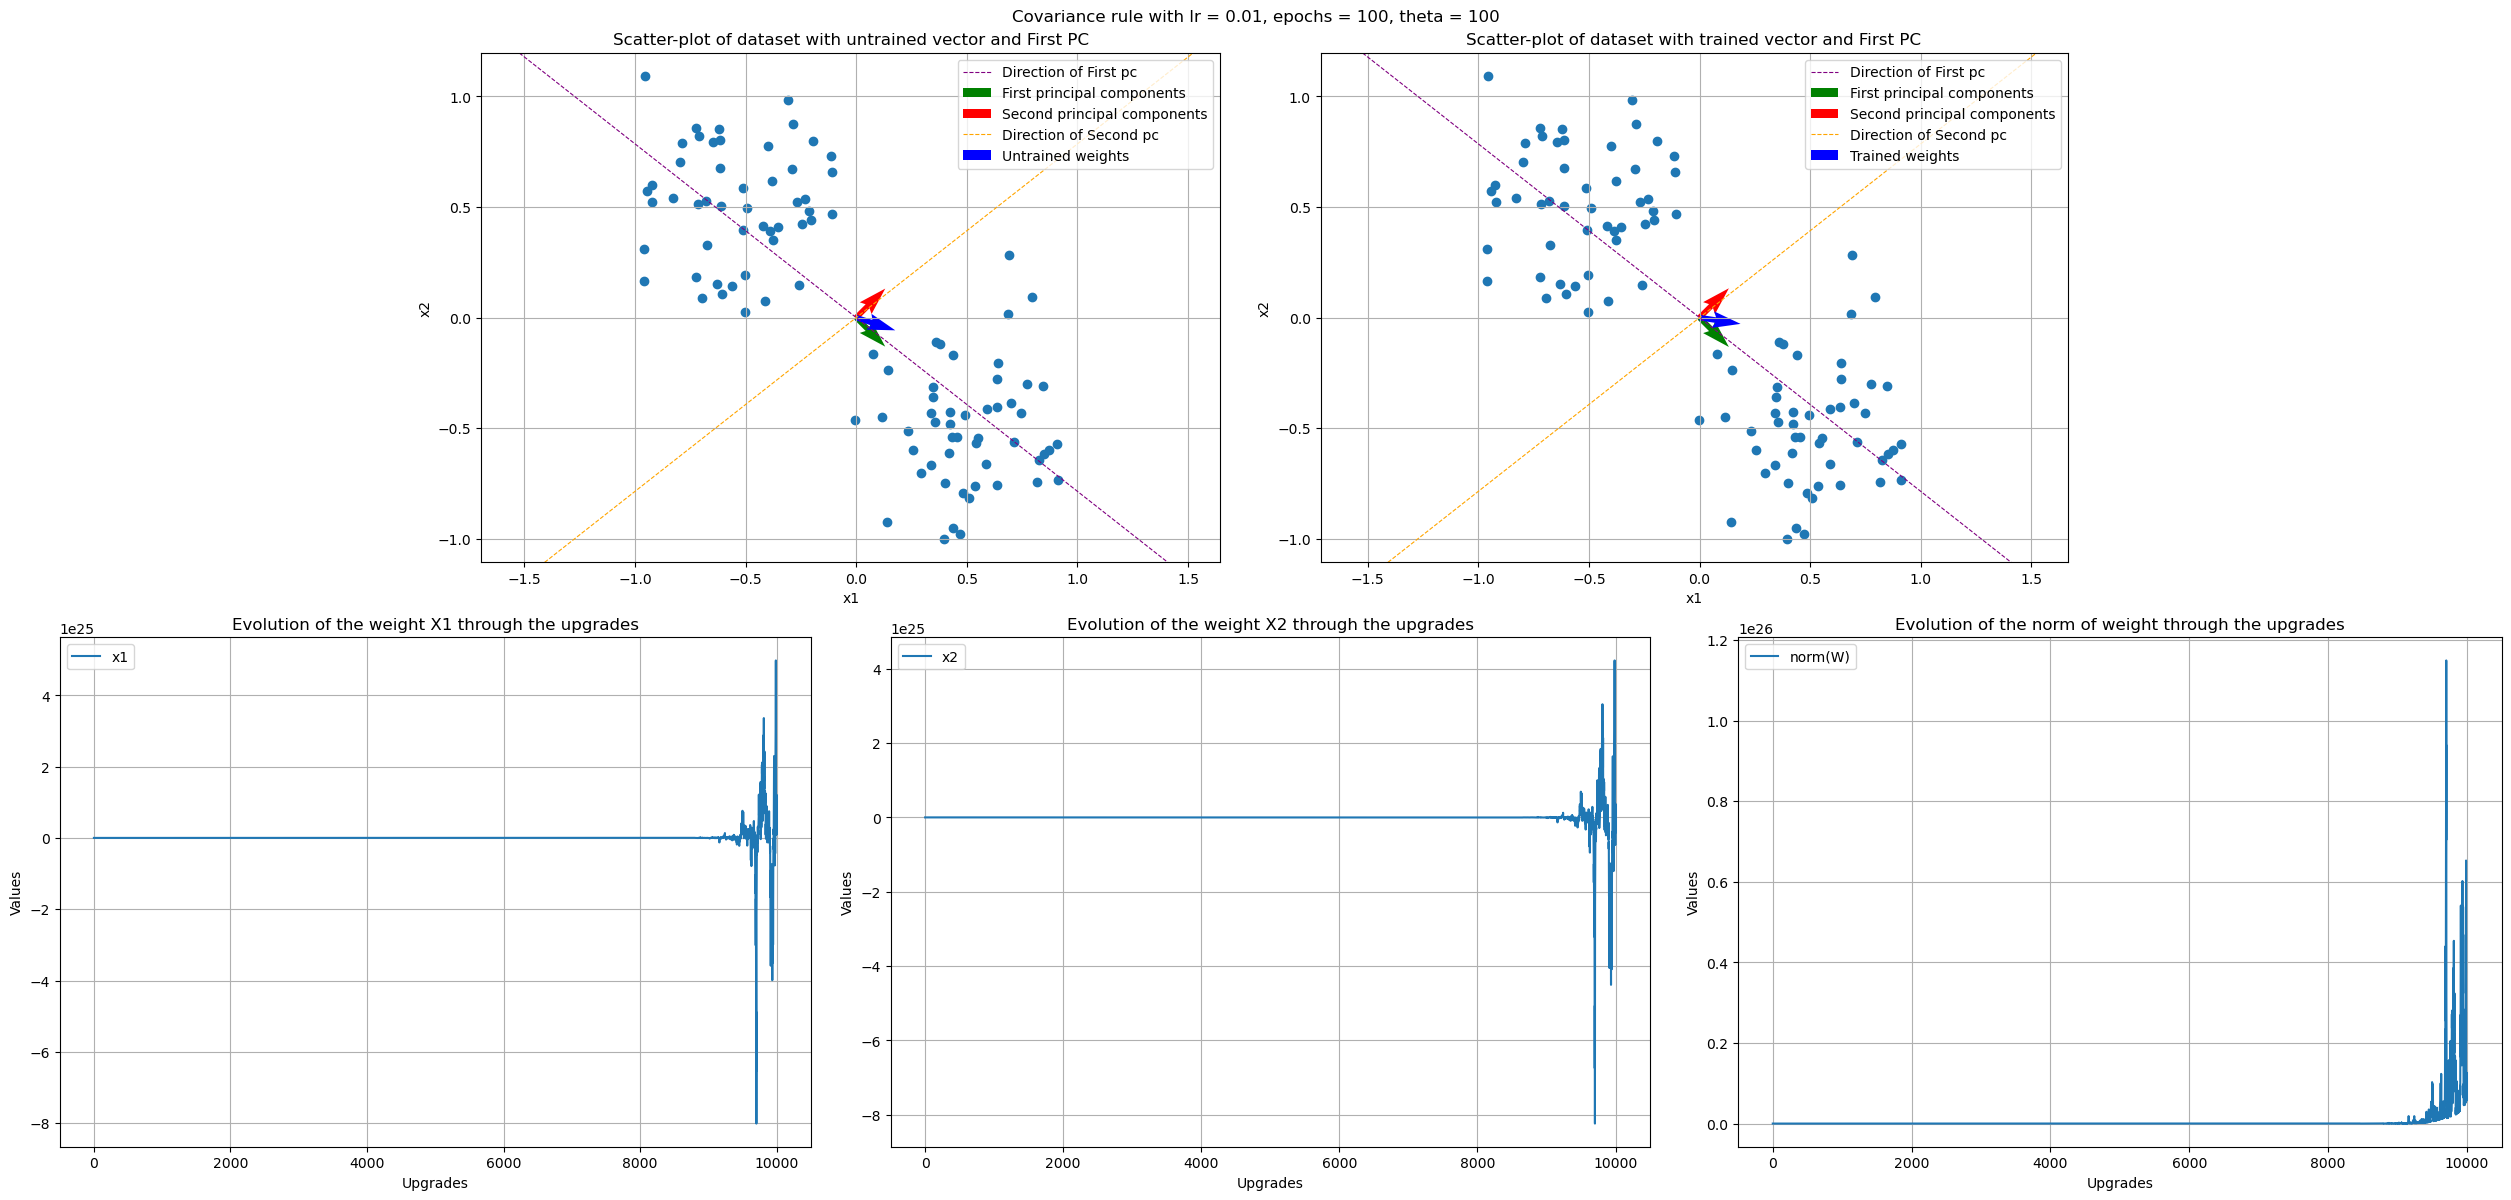

In [31]:
conv_rule = Covariance_rule(theta = 100,
                           source = source1.T,
                           lr=0.01,
                           epochs=100,
                           threshold=1e-05)

untrained_W = copy(conv_rule.W)
conv_rule()

plot_results(
    "Covariance rule with lr = 0.01, epochs = 100, theta = 100",
    source1,
    untrained_W,
    conv_rule.W,
    conv_rule.history_x1,
    conv_rule.history_x2,
    second_component=True,
    filename="10 - Covariance lr 0_01 epochs 100 theta 100")

##Bonus Track Assignment 3 – Dataset #2

In [32]:
source2 = pd.read_csv("dataset2_lab_2_1.csv", header=None).to_numpy()

In [33]:
first_pc2, second_pc2 = principal_components(source2)

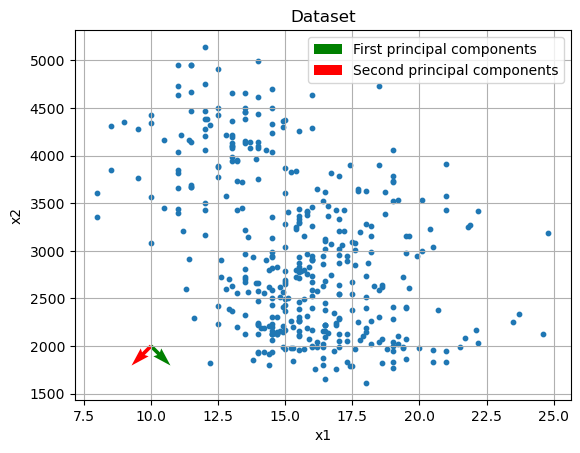

In [34]:
plt.scatter(*source2, s=10)

origin_x, origin_y = 10, 2000

plt.quiver(origin_x, origin_y, first_pc2[0], first_pc2[1], label="First principal components",color="green")
plt.quiver(origin_x, origin_y, second_pc2[0], second_pc2[1], label="Second principal components", color="red")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset")
plt.grid()
plt.legend()
plt.show()

### Classic Hebbian learning


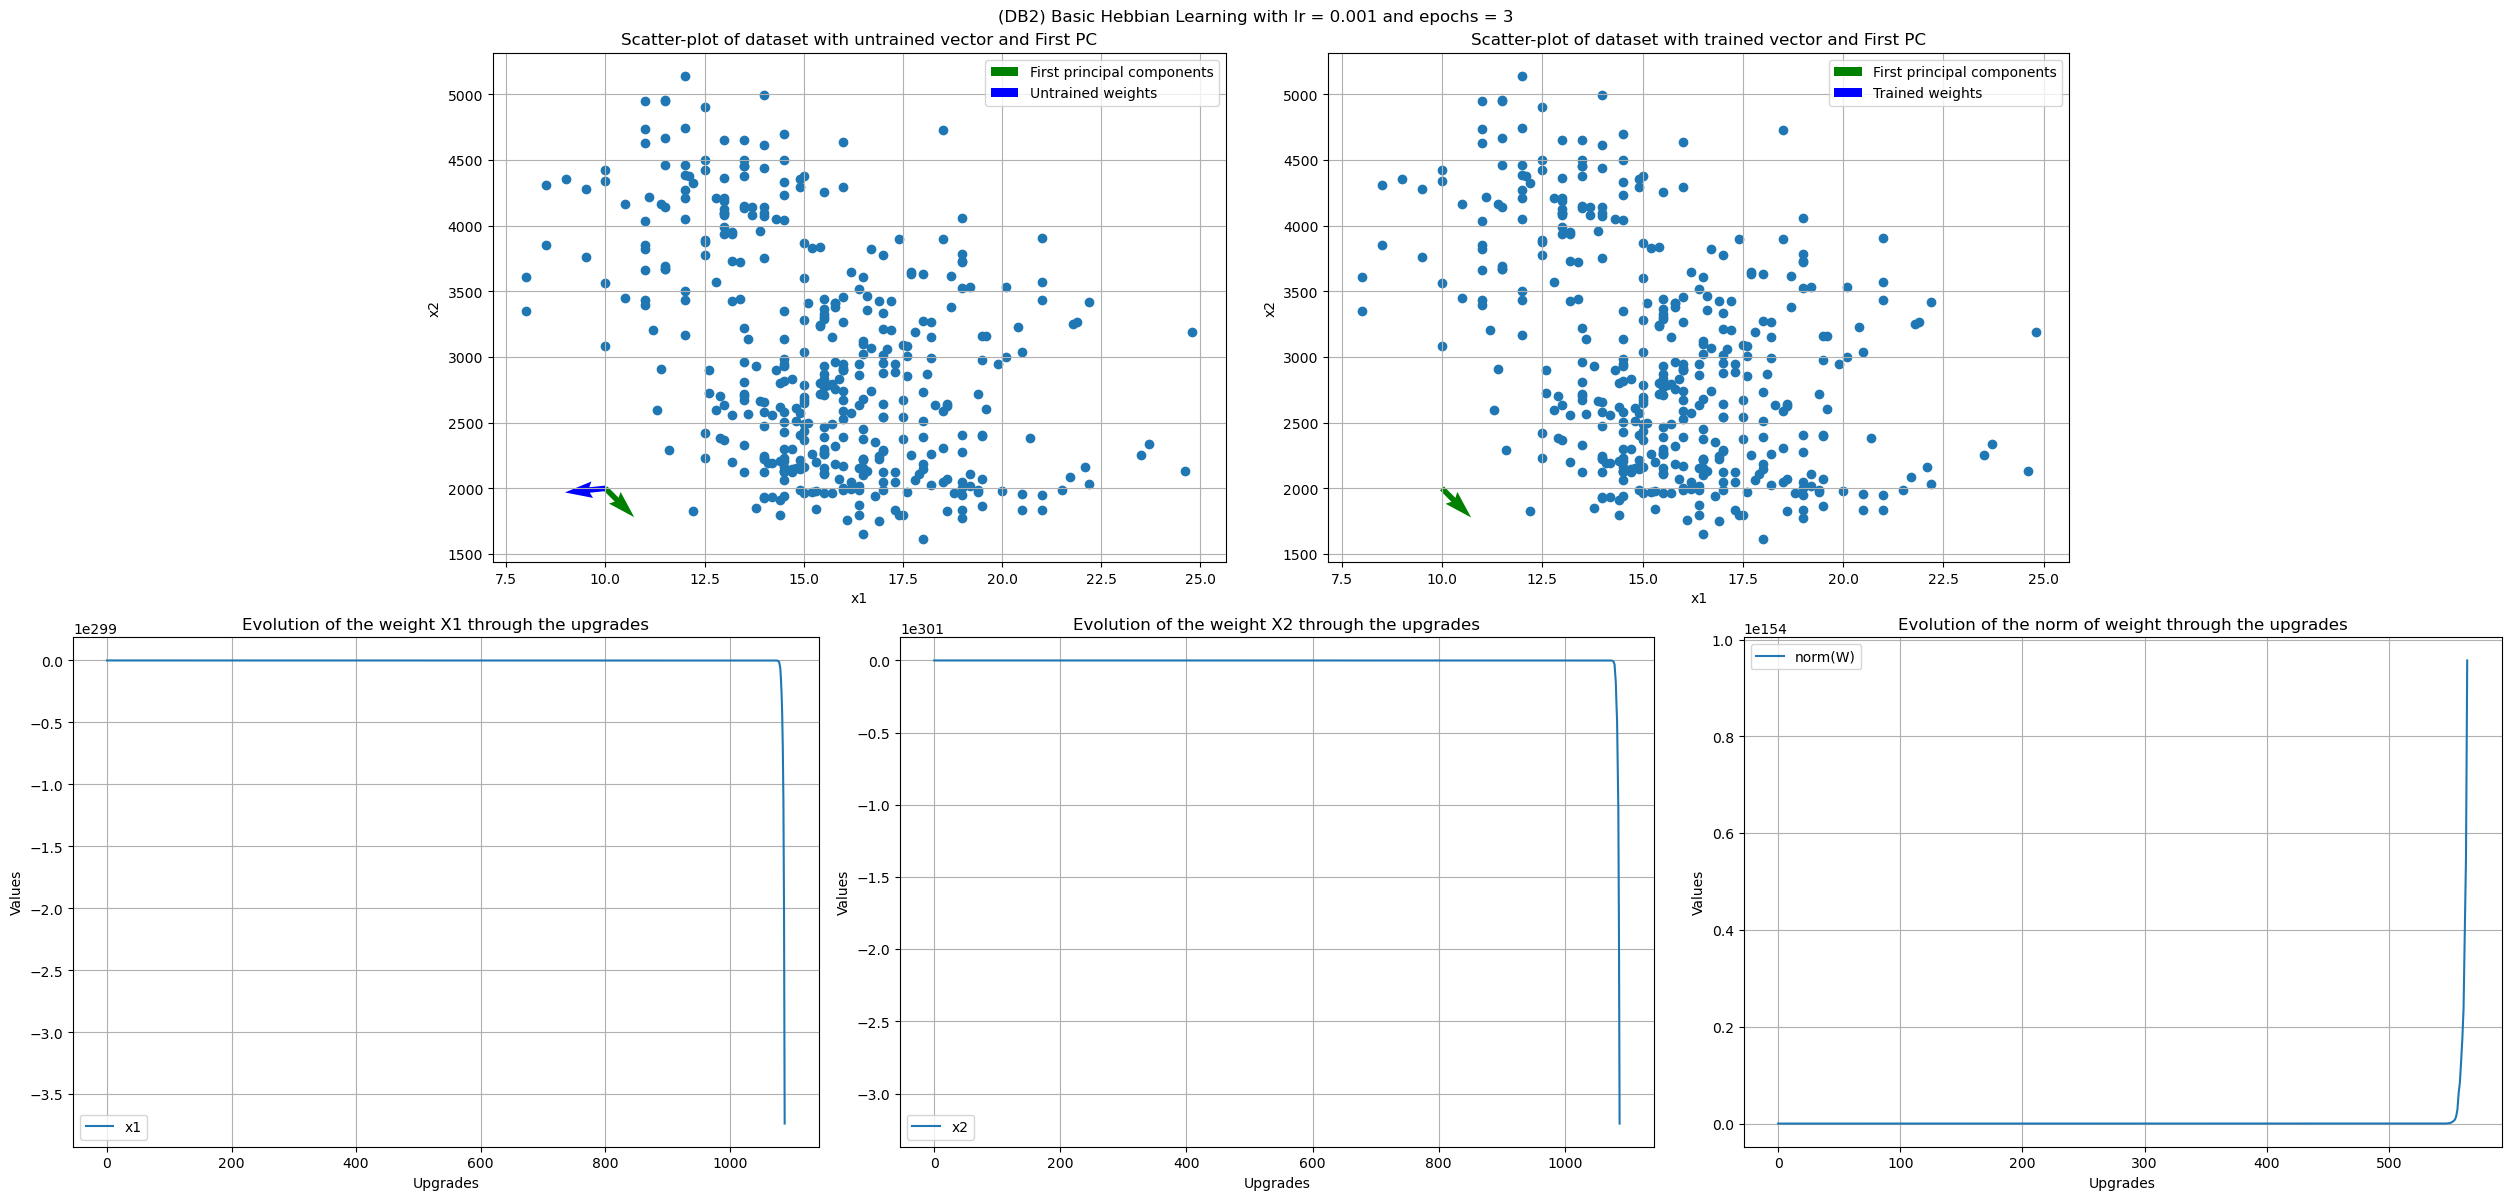

In [35]:
hebbianL = Hebbian_learning(source2.T, lr=1e-07, epochs=3)
untrained_W = copy(hebbianL.W)

with warnings.catch_warnings(): # cause overflow!!
  warnings.filterwarnings('ignore')
  hebbianL()

  plot_results2(
      "(DB2) Basic Hebbian Learning with lr = 0.001 and epochs = 3",
      source2,
      untrained_W,
      hebbianL.W,
      hebbianL.history_x1,
      hebbianL.history_x2,
      filename="11 - DB2 Hebbian lr 0_01 epochs 3 theta 100")

### Oja Rule

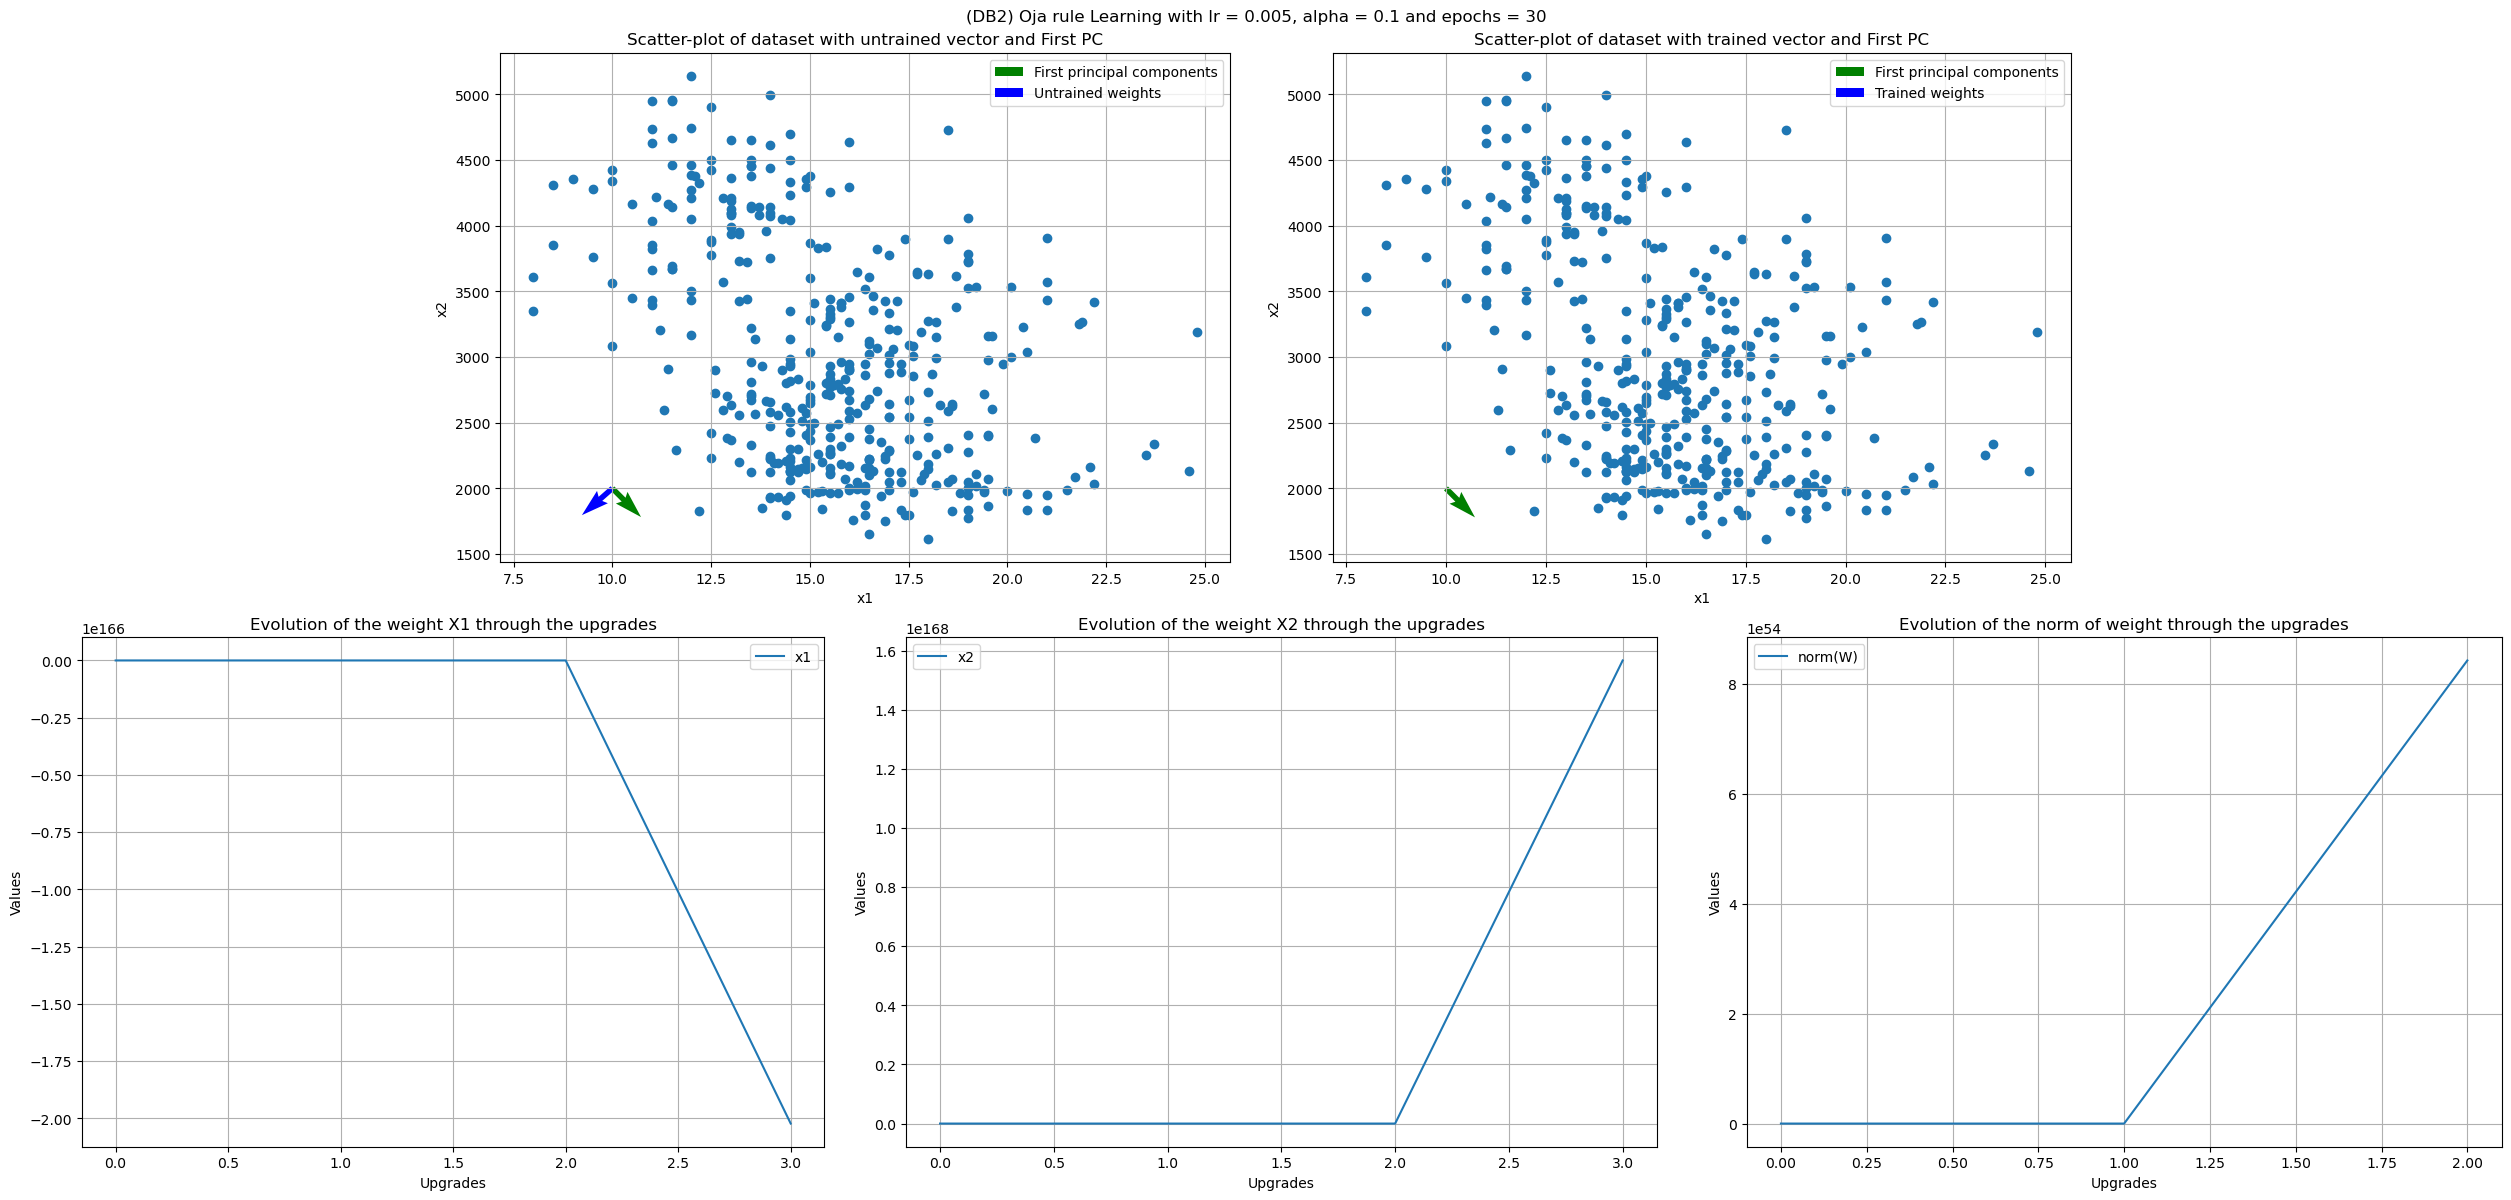

In [36]:
oja_rule = Oja_rule(alpha = 0.1, source = source2.T, lr=0.005, epochs=30)
untrained_W = copy(oja_rule.W)

with warnings.catch_warnings(): # cause overflow!!
  warnings.filterwarnings('ignore')
  oja_rule()

  plot_results2(
      "(DB2) Oja rule Learning with lr = 0.005, alpha = 0.1 and epochs = 30",
      source2,
      untrained_W,
      oja_rule.W,
      oja_rule.history_x1,
      oja_rule.history_x2,
      filename="12 - DB2 Oja rule lr 0_005 epochs 30 alpha 0_1")

### Subtractive rule

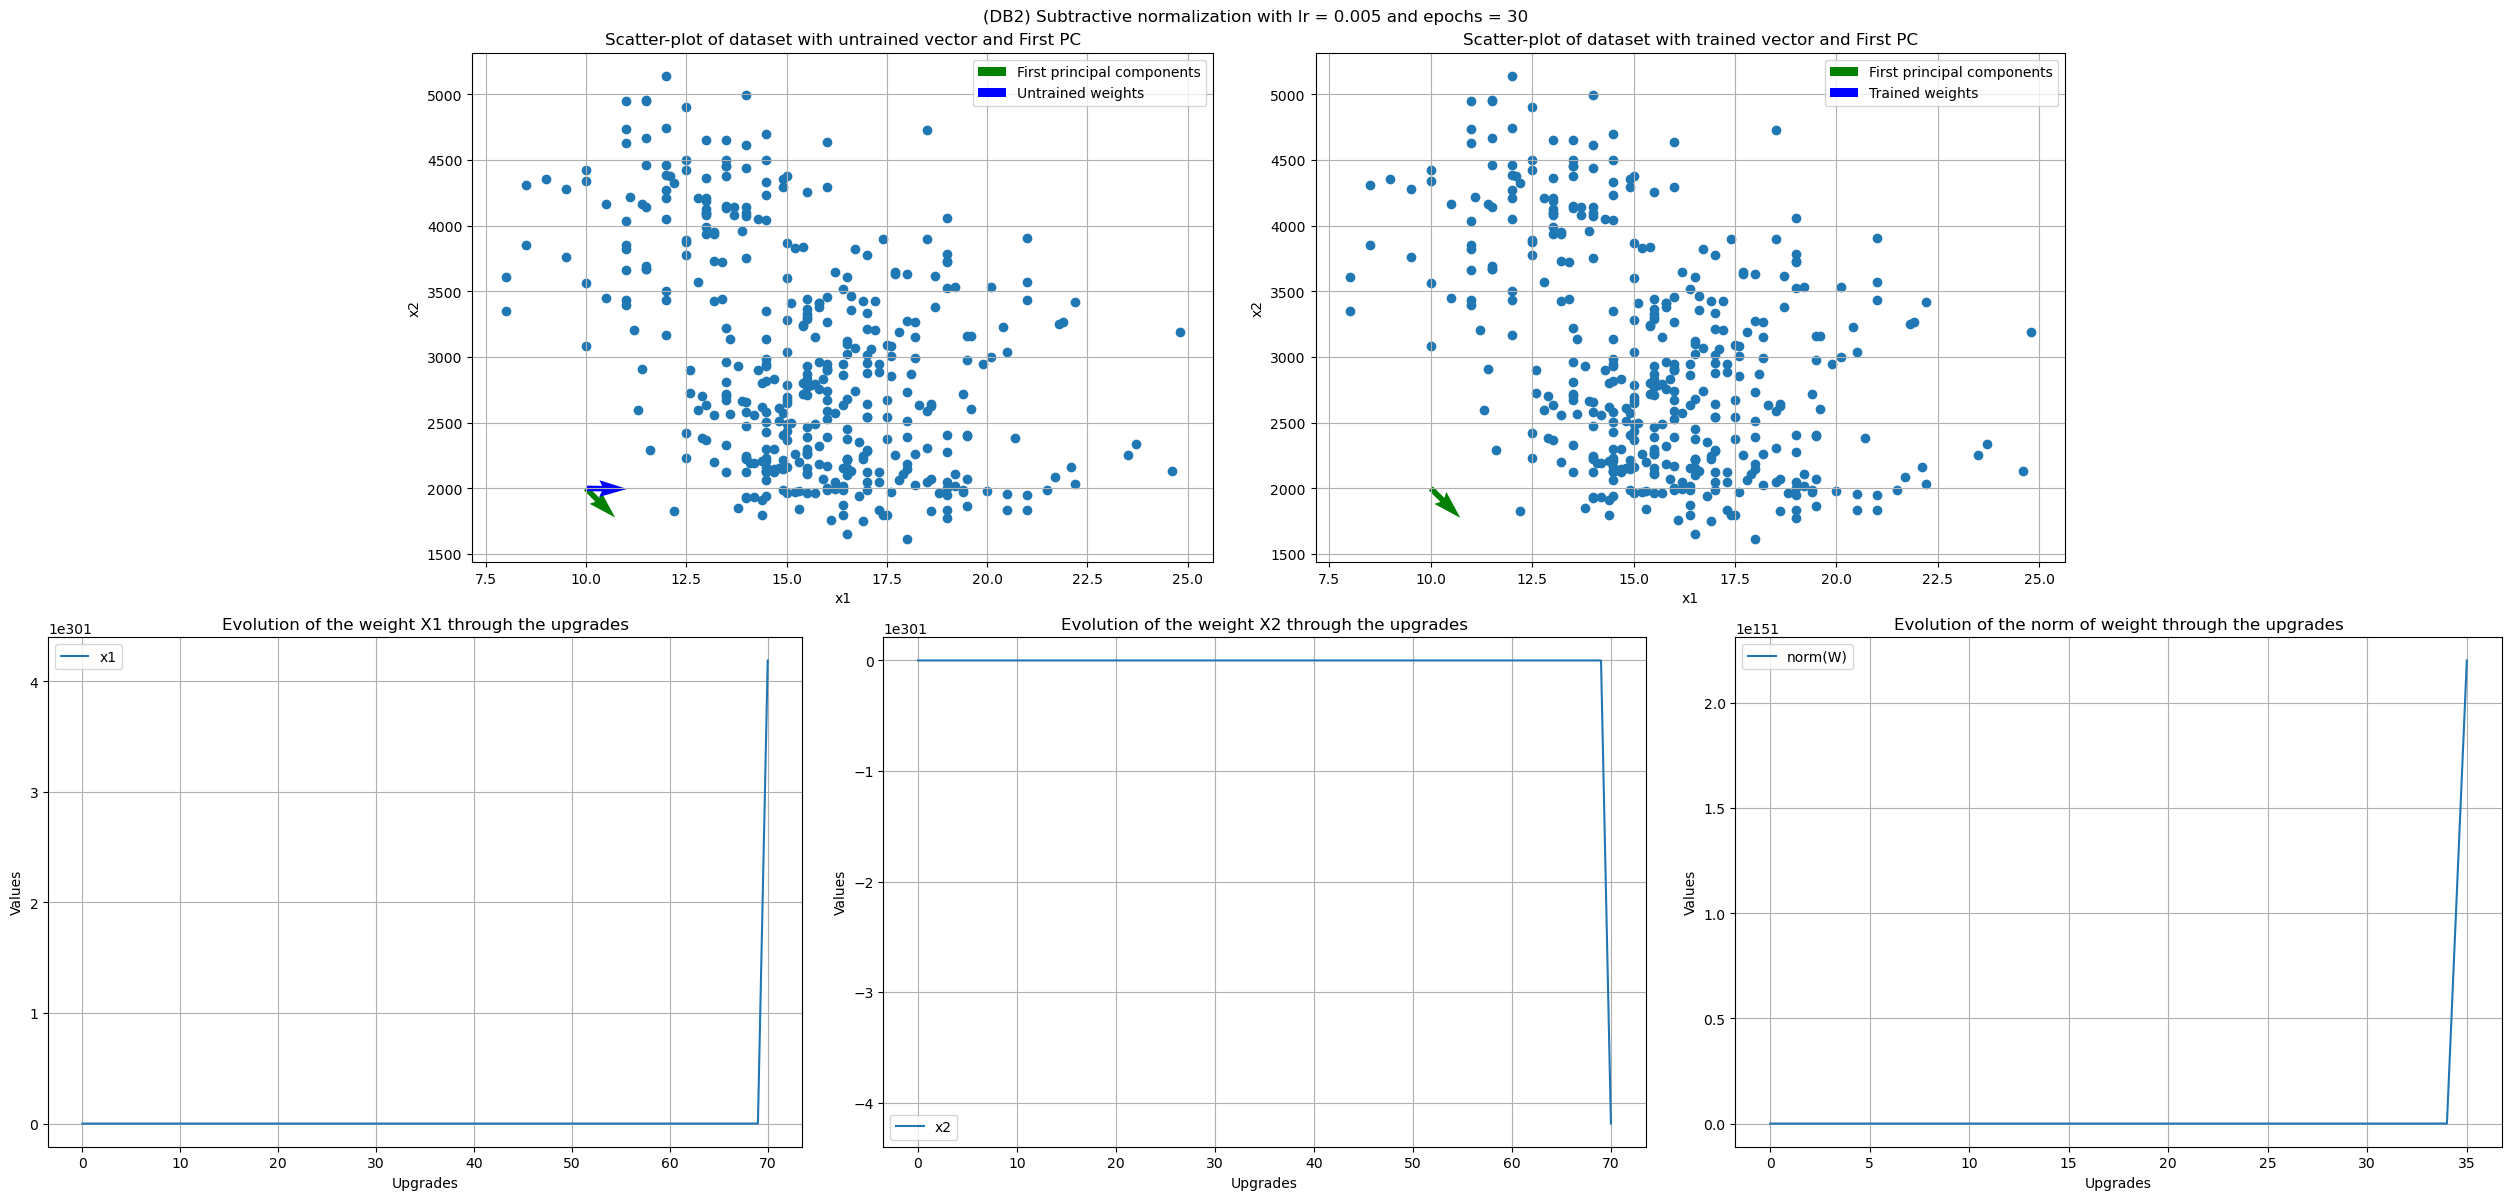

In [37]:
subtractive = Subtractive(source = source2.T, lr=0.005, epochs=30)
untrained_W = copy(subtractive.W)

with warnings.catch_warnings(): # cause overflow!!
  warnings.filterwarnings('ignore')
  subtractive()

  plot_results2(
      "(DB2) Subtractive normalization with lr = 0.005 and epochs = 30",
      source2,
      untrained_W,
      subtractive.W,
      subtractive.history_x1,
      subtractive.history_x2,
      filename="13 - DB2 Subtractive lr 0_005 epochs 30")

### BCM Rule

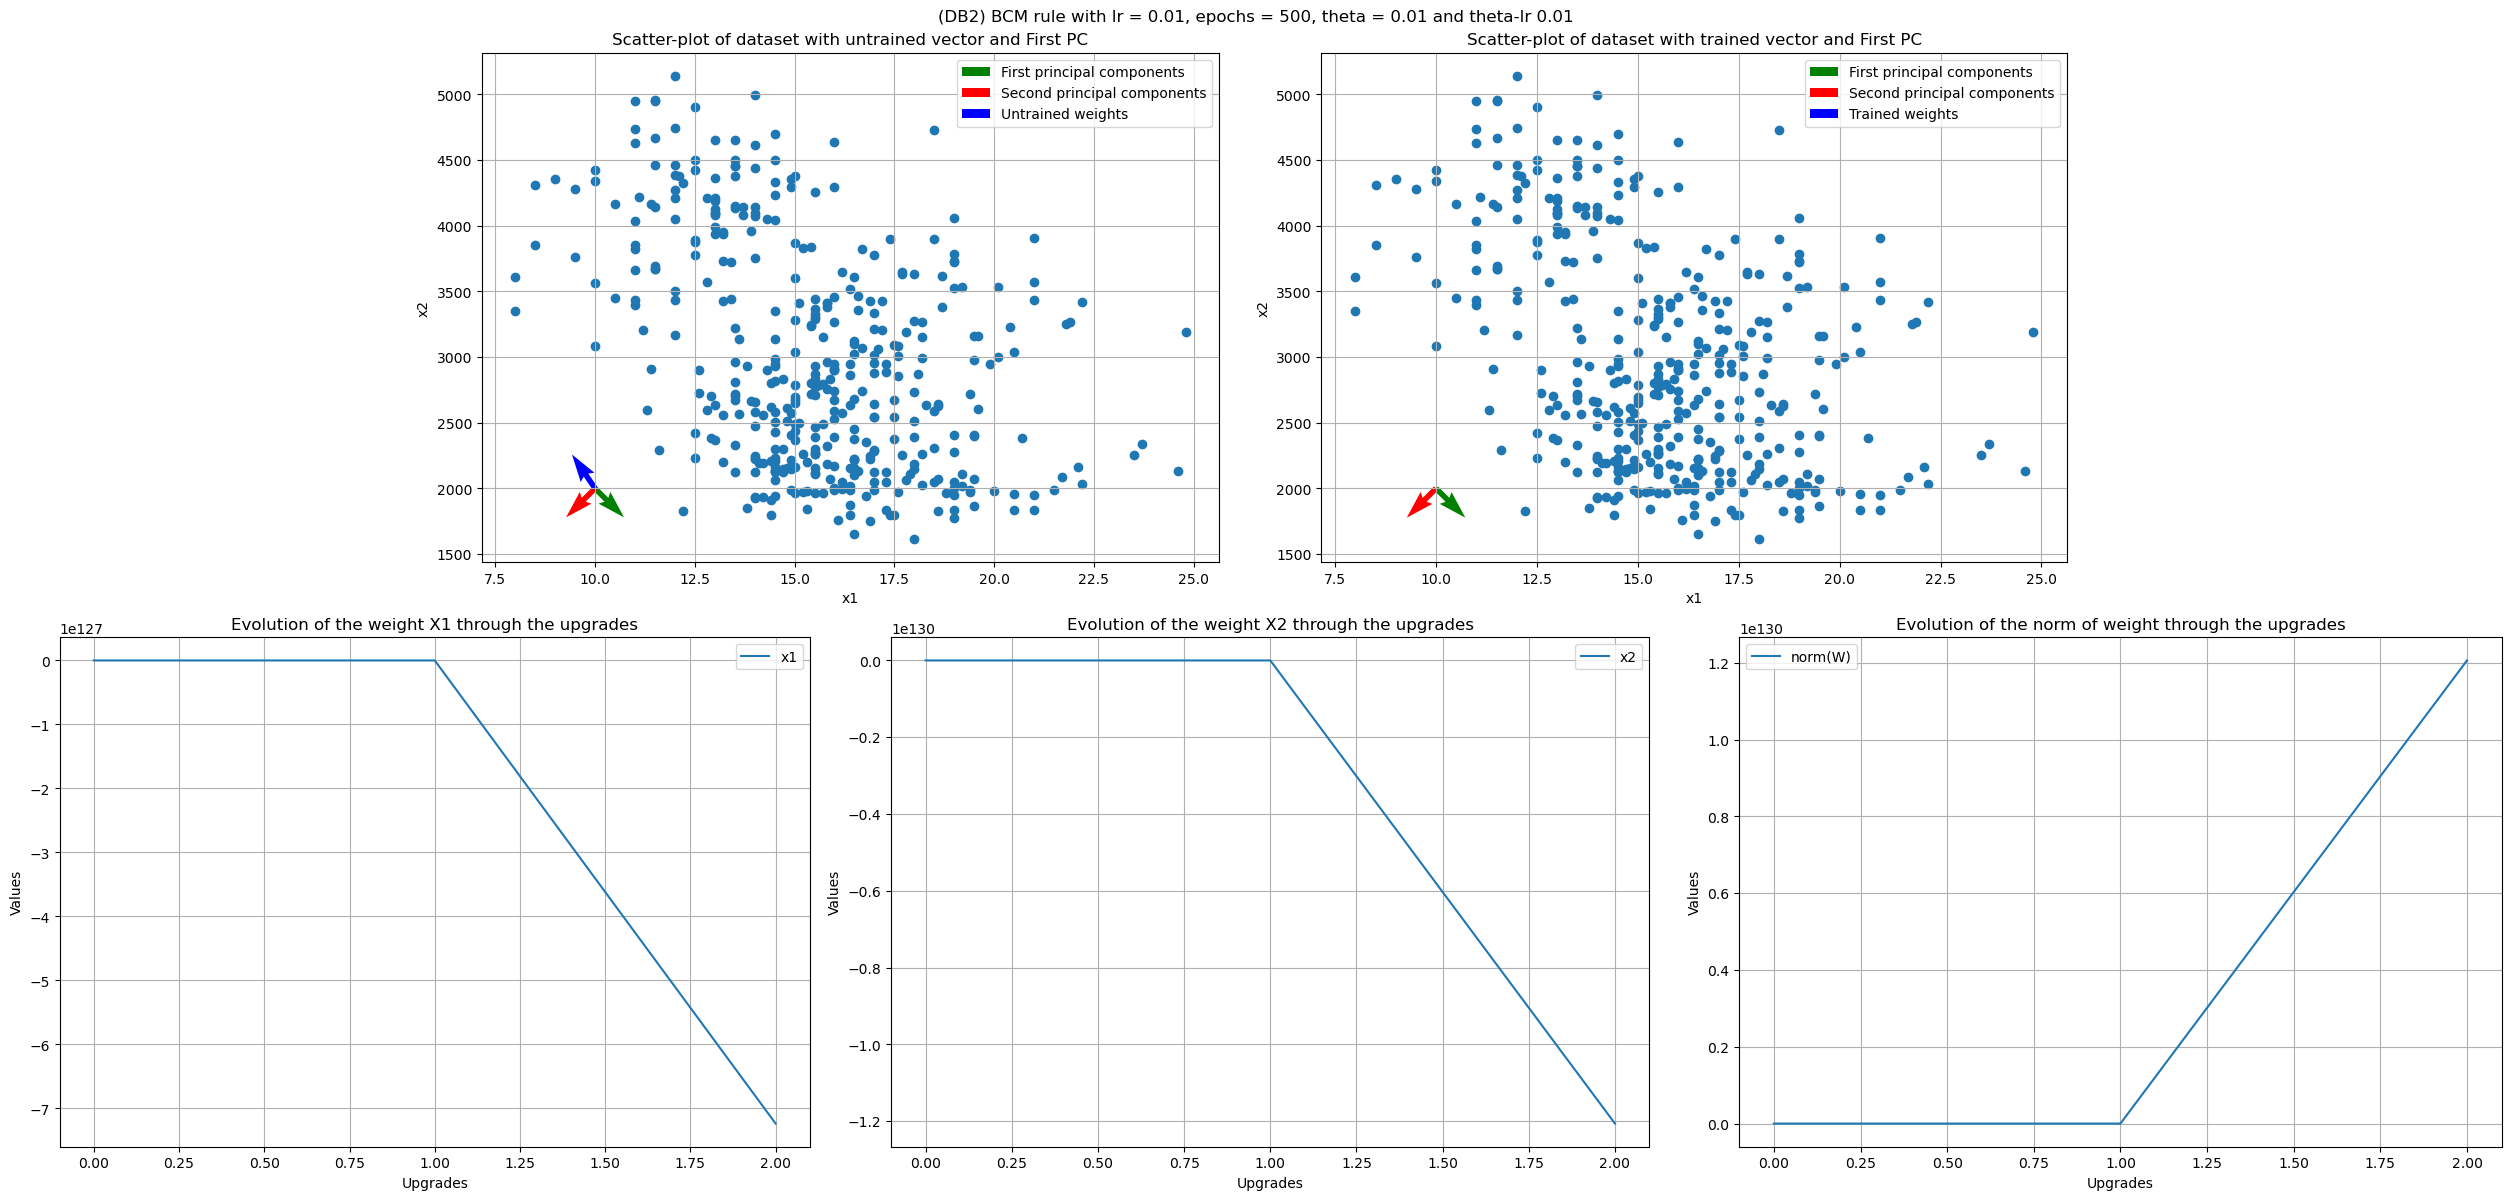

In [38]:
bcm_rule = BCM_Rule(theta = 0.01,
                    theta_lr = 0.01,
                    source = source2.T,
                    lr=0.01,
                    epochs=500,
                    threshold=1e-05)

untrained_W = copy(bcm_rule.W)


with warnings.catch_warnings(): # cause overflow!!
  warnings.filterwarnings('ignore')
  bcm_rule()

  plot_results2(
      "(DB2) BCM rule with lr = 0.01, epochs = 500, theta = 0.01 and theta-lr 0.01",
      source2,
      untrained_W,
      bcm_rule.W,
      bcm_rule.history_x1,
      bcm_rule.history_x2,
      second_component=True,
      filename="14 - DB2 BCM lr 0_01 epochs 500 theta 0_01 theta_lr 0_01")

### Covariance Rule

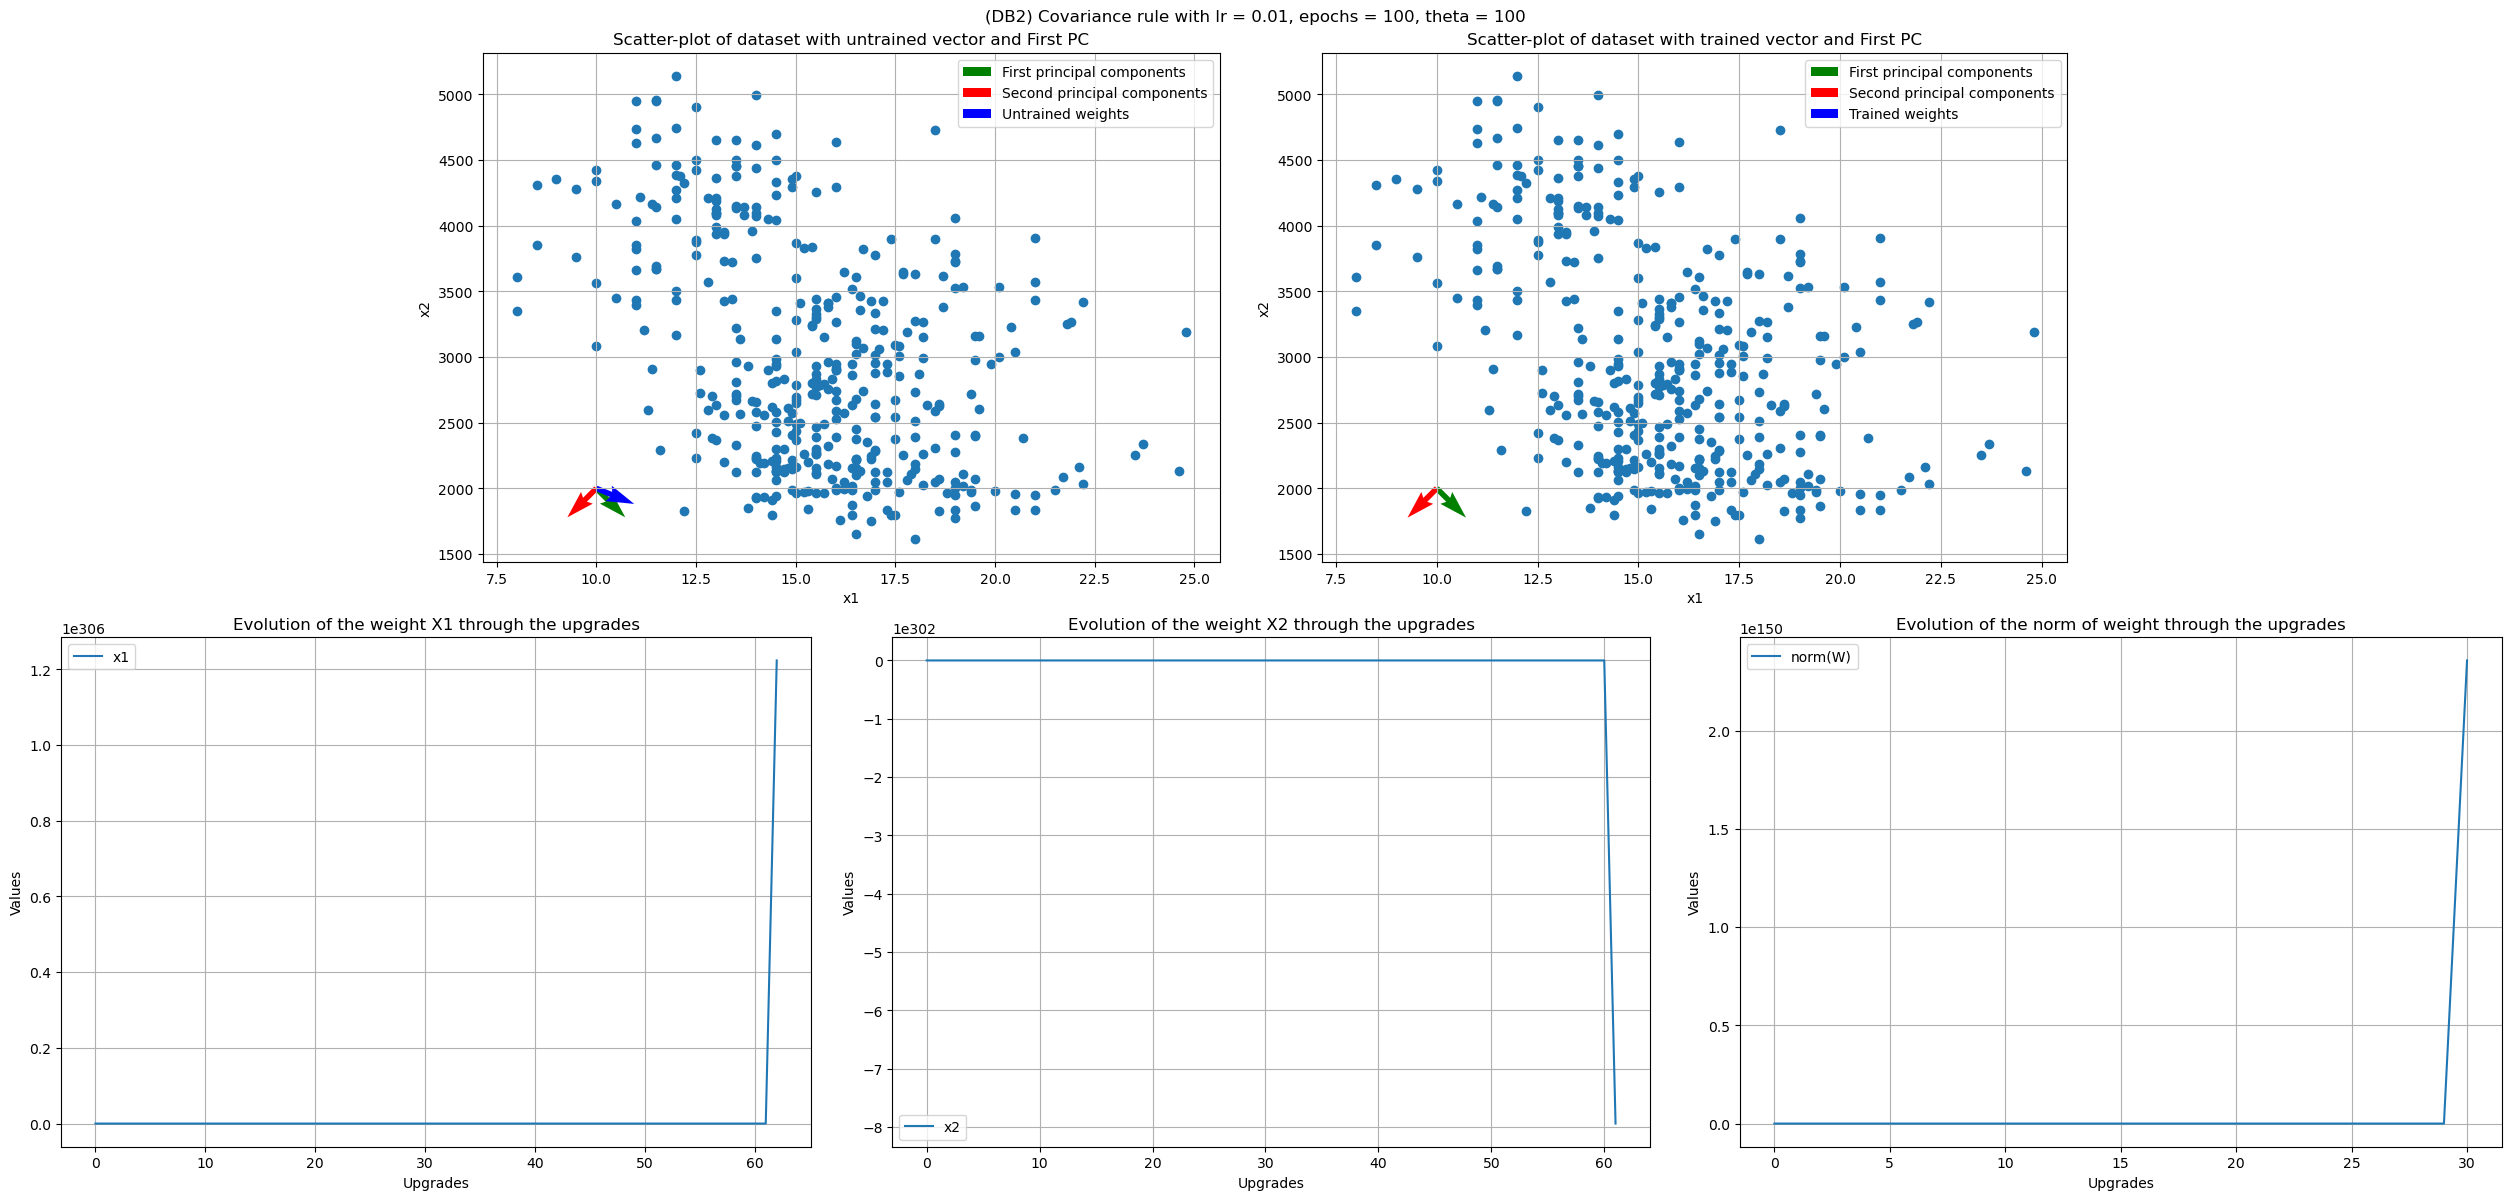

In [39]:
conv_rule = Covariance_rule(theta = 100,
                           source = source2.T,
                           lr=0.01,
                           epochs=100,
                           threshold=1e-05)

untrained_W = copy(conv_rule.W)

with warnings.catch_warnings(): # cause overflow!!
  warnings.filterwarnings('ignore')
  conv_rule()

  plot_results2(
      "(DB2) Covariance rule with lr = 0.01, epochs = 100, theta = 100",
      source2,
      untrained_W,
      conv_rule.W,
      conv_rule.history_x1, 
      conv_rule.history_x2,
      second_component=True,
      filename="15 - DB2 Covariance lr 0_01 epochs 100 theta 100")

In [40]:
shutil.make_archive("imgs", 'zip', "imgs/")

'K:\\Universita\\[IA] Artificial Intelligence\\[CNS] Computational NeuroScience\\Labs\\LAB-to-deliver\\LAB2_1\\imgs.zip'